In [1]:
!pip install pycaret

In [96]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, classification_report
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from pycaret.regression import *
from pycaret.classification import plot_model
from pycaret.regression import setup, create_model, plot_model

In [3]:
# Carregar os dados
df = pd.read_feather("/content/credit_scoring.ftr")

In [4]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [6]:
# Converter data_ref para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [7]:
# Separar os três últimos meses como OOT
ultimos_3_meses = df['data_ref'].sort_values().unique()[-3:]
df_dev = df[~df['data_ref'].isin(ultimos_3_meses)]
df_oot = df[df['data_ref'].isin(ultimos_3_meses)]

In [8]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'index']
df_dev = df_dev.drop(columns=colunas_para_remover)
df_oot = df_oot.drop(columns=colunas_para_remover)

In [9]:
# Função para tratar outliers
def tratar_outliers(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    return serie.clip(limite_inferior, limite_superior)

In [10]:
# Função para agrupar categorias raras
def agrupar_categorias_raras(serie, threshold=0.05):
    contagem = serie.value_counts(normalize=True)
    categorias_raras = contagem[contagem < threshold].index
    return serie.replace(categorias_raras, 'Outros')

In [11]:
# Tratamento de valores missing, outliers e zeros estruturais
for col in df_dev.columns:
    if df_dev[col].dtype in ['int64', 'float64'] and col != 'inadimplente':
        # Tratar zeros estruturais
        if (df_dev[col] == 0).sum() / len(df_dev) > 0.1:  # Se mais de 10% são zeros
            df_dev[f'{col}_zero'] = (df_dev[col] == 0).astype(int)
            df_dev.loc[df_dev[col] == 0, col] = np.nan

        # Imputar valores missing com mediana
        df_dev[col] = df_dev[col].fillna(df_dev[col].median())

        # Tratar outliers
        df_dev[col] = tratar_outliers(df_dev[col])
    elif df_dev[col].dtype == 'object':
        # Agrupar categorias raras
        df_dev[col] = agrupar_categorias_raras(df_dev[col])

        # Tratar valores missing em variáveis categóricas
        df_dev[col] = df_dev[col].fillna('Desconhecido')

In [12]:
# Separar features e target
X = df_dev.drop('idade', axis=1)
y = df_dev['idade']

In [13]:
# One-hot encoding para variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

In [14]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Treinar o modelo de regressão logística
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [17]:
# Avaliar o modelo
y_pred_proba = model.predict_proba(X_test_scaled)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC no conjunto de teste: {auc:.4f}")
print("\nClassification Report no conjunto de teste:")
print(classification_report(y_test, model.predict(X_test_scaled)))

AUC no conjunto de teste: 0.7965

Classification Report no conjunto de teste:
              precision    recall  f1-score   support

          22       0.31      0.25      0.27        81
          23       0.27      0.17      0.20       235
          24       0.13      0.10      0.12       827
          25       0.04      0.03      0.03      1108
          26       0.00      0.00      0.00      1445
          27       0.09      0.22      0.13      3474
          28       0.07      0.13      0.09      3469
          29       0.10      0.01      0.02      2837
          30       0.13      0.19      0.16      3358
          31       0.11      0.15      0.13      3127
          32       0.13      0.08      0.10      3495
          33       0.11      0.06      0.08      3515
          34       0.10      0.11      0.10      3522
          35       0.09      0.02      0.03      3249
          36       0.13      0.15      0.14      3202
          37       0.10      0.18      0.13      3864
   

In [18]:
# Avaliar no conjunto OOT
X_oot = df_oot.drop('idade', axis=1)
X_oot = pd.get_dummies(X_oot, drop_first=True)
X_oot = X_oot.reindex(columns=X.columns, fill_value=0)

# Imputar valores ausentes usando SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_oot_imputed = imputer.fit_transform(X_oot)

X_oot_scaled = scaler.transform(X_oot_imputed)
y_oot = df_oot['idade']

y_oot_pred_proba = model.predict_proba(X_oot_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"\nAUC no conjunto OOT: {auc:.4f}")
print("\nClassification Report no conjunto OOT:")
print(classification_report(y_oot, model.predict(X_oot_scaled)))


AUC no conjunto OOT: 0.7965

Classification Report no conjunto OOT:
              precision    recall  f1-score   support

          22       0.00      0.00      0.00        96
          23       0.38      0.21      0.28       270
          24       0.00      0.00      0.00       971
          25       0.06      0.39      0.11      1418
          26       0.00      0.00      0.00      1806
          27       0.04      0.01      0.02      4310
          28       0.06      0.17      0.09      4240
          29       0.25      0.01      0.03      3598
          30       0.12      0.14      0.13      4088
          31       0.08      0.10      0.09      3936
          32       0.00      0.00      0.00      4408
          33       0.09      0.01      0.01      4270
          34       0.09      0.12      0.10      4381
          35       0.09      0.01      0.01      4025
          36       0.11      0.15      0.13      3981
          37       0.11      0.23      0.15      4772
          38

In [19]:
# Usar statsmodels para obter p-valores
X_train_sm = sm.add_constant(X_train_scaled)

# Por exemplo, se y_train for contínuo, pode ser necessário limitá-lo:
y_train_binary = (y_train > y_train.mean()).astype(int)

# Verifique e descarte recursos com variação zero
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X_train_sm = selector.fit_transform(X_train_sm)

# Calcule e inspecione a matriz de correlação
corr_matrix = np.corrcoef(X_train_sm, rowvar=False)
print(corr_matrix)

# Ajustar o modelo com potencialmente menos recursos
model_sm = sm.Logit(y_train_binary, X_train_sm)
results = model_sm.fit()
print(results.summary())

[[ 1.00000000e+00 -1.23079272e-02  6.24365281e-01 -1.15217567e-01
   4.65326253e-02 -9.73863078e-02 -4.04516975e-02 -9.35797598e-03
  -7.25932611e-02  1.77485585e-02 -8.77714358e-02  1.57032785e-01
  -4.76323647e-02 -9.62010952e-03  4.36703516e-03  1.21911305e-02
  -3.84774963e-02 -1.33063374e-02 -4.60560425e-02]
 [-1.23079272e-02  1.00000000e+00 -2.51288957e-02  2.16020302e-03
  -7.99726262e-01  1.57396762e-01  1.66946286e-01 -1.64511637e-02
   1.99355192e-02 -5.18347299e-03 -2.35468034e-01  5.50173019e-02
   1.28901628e-02  4.72562919e-02 -2.74305430e-01 -2.40008665e-01
  -4.35439613e-01  7.44407454e-02  1.77256348e-02]
 [ 6.24365281e-01 -2.51288957e-02  1.00000000e+00 -1.69765420e-01
   4.08349395e-02 -3.06449343e-02 -1.10023262e-02  6.08139219e-02
   8.35870647e-03  6.38678522e-03 -1.14904121e-01  1.23042493e-01
  -2.94957783e-02  4.50309864e-02 -2.82744534e-03  8.81640853e-03
  -8.12434607e-03 -7.32668719e-03 -3.18009451e-02]
 [-1.15217567e-01  2.16020302e-03 -1.69765420e-01  1.00

In [20]:
# Criar equação preditiva
coef_dict = dict(zip(X.columns, model.coef_[0]))
intercept = model.intercept_[0]

print("\nEquação Preditiva para 'inadimplente':")
equation = f"log(odds) = {intercept:.4f}"
for feature, coef in coef_dict.items():
    if abs(coef) > 0.001:  # Mostrar apenas coeficientes significativos
        equation += f" + ({coef:.4f} * {feature})"
print(equation)


Equação Preditiva para 'inadimplente':
log(odds) = -5.4932 + (-1.5502 * tempo_emprego) + (-0.1696 * qt_pessoas_residencia) + (0.2045 * renda) + (-0.0413 * mau) + (-0.6162 * qtd_filhos_zero) + (-0.0107 * sexo_M) + (-1.9623 * posse_de_veiculo_S) + (0.6117 * posse_de_imovel_S) + (-0.1245 * tipo_renda_Empresário) + (0.0822 * tipo_renda_Outros) + (-0.4915 * tipo_renda_Pensionista) + (-0.9801 * tipo_renda_Servidor público) + (0.6807 * educacao_Outros) + (0.2871 * educacao_Superior completo) + (-0.1057 * estado_civil_Outros) + (0.2743 * estado_civil_Separado) + (0.3530 * estado_civil_Solteiro) + (0.3549 * estado_civil_União) + (0.9992 * tipo_residencia_Outros)


In [21]:
# Identificar categorias não significantes
print("\nCategorias não significantes (p-valor > 0.05):")
for feature, p_value in zip(X.columns, results.pvalues[1:]):
    if p_value > 0.05:
        print(f"{feature}: p-valor = {p_value:.4f}")


Categorias não significantes (p-valor > 0.05):
qt_pessoas_residencia: p-valor = 0.1436


In [22]:
# Descrição geral da base
print("Descrição geral da base:")
print(f"Número total de linhas: {len(df)}")
print(f"Número de colunas: {df.shape[1]}")

Descrição geral da base:
Número total de linhas: 750000
Número de colunas: 15


In [23]:
# Número de linhas por mês
linhas_por_mes = df.groupby(df['data_ref'].dt.to_period('M')).size().sort_index()
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)


Número de linhas por mês:
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, dtype: int64


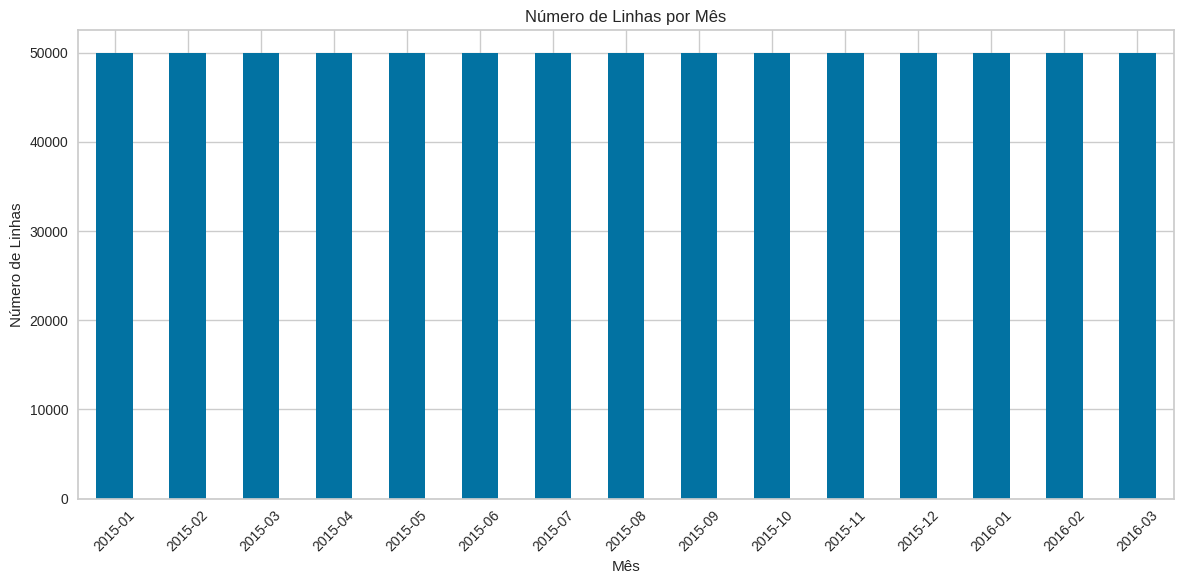

In [24]:
# Plotar número de linhas por mês
plt.figure(figsize=(12, 6))
linhas_por_mes.plot(kind='bar')
plt.title('Número de Linhas por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Linhas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Identificar variáveis qualitativas e quantitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'category']).columns
variaveis_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns
variaveis_quantitativas = [col for col in variaveis_quantitativas if col not in ['index', 'inadimplente']]


Análise univariada para variáveis qualitativas:

sexo:
sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


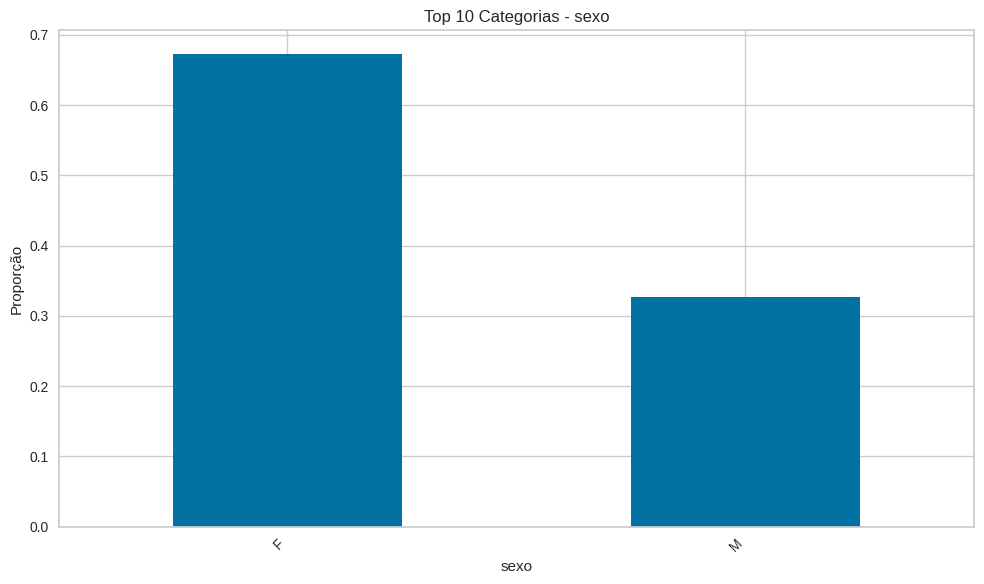


posse_de_veiculo:
posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


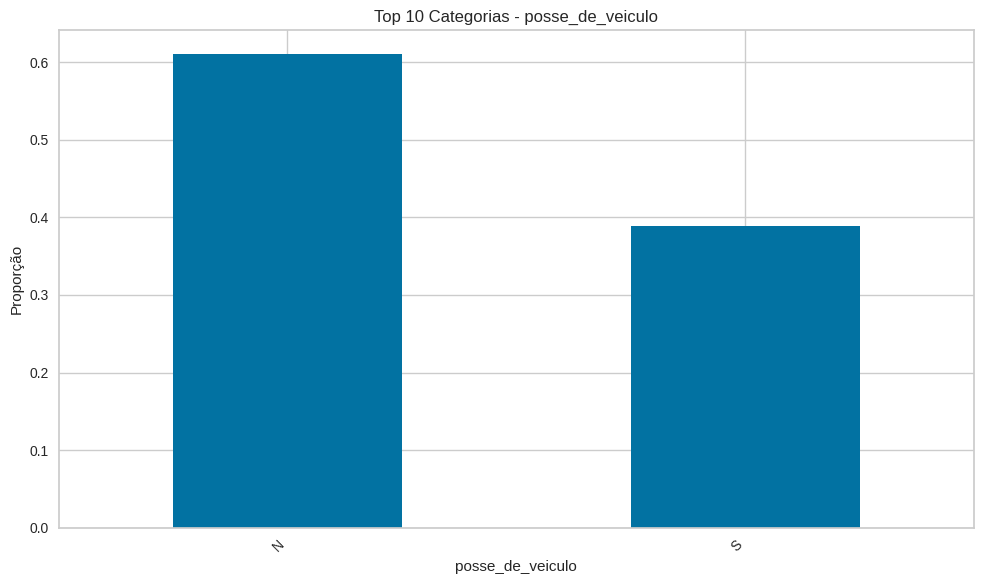


posse_de_imovel:
posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


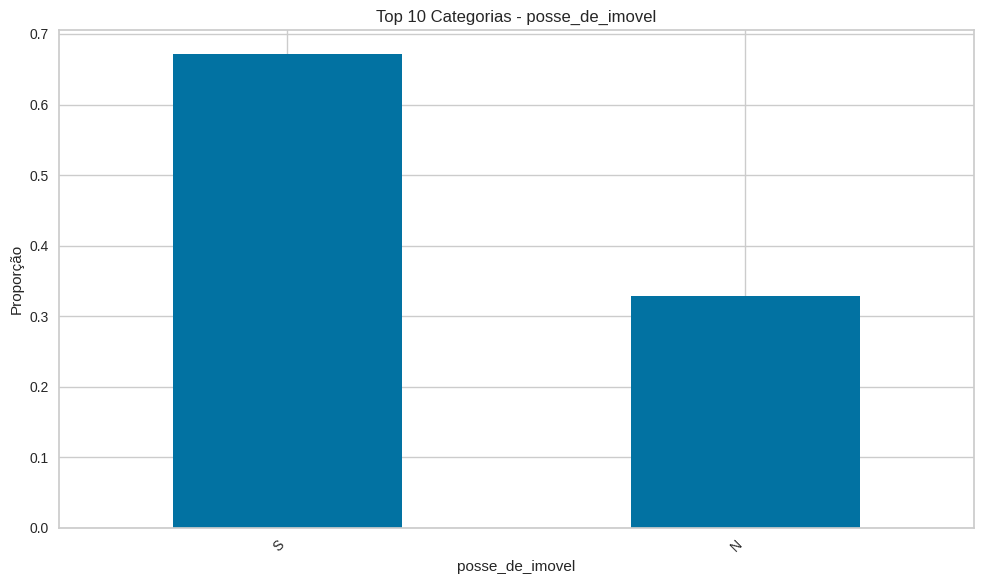


tipo_renda:
tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


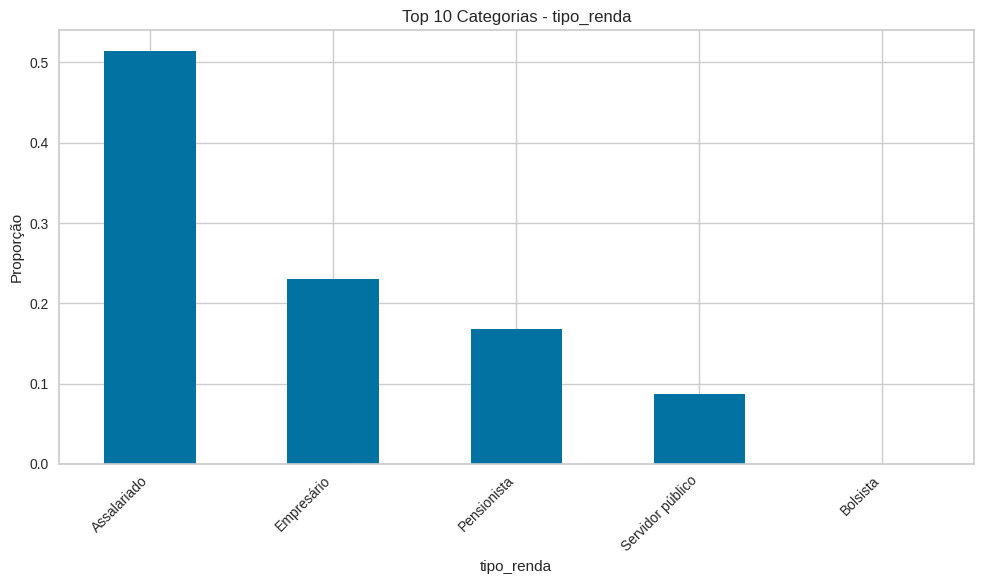


educacao:
educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.001083
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


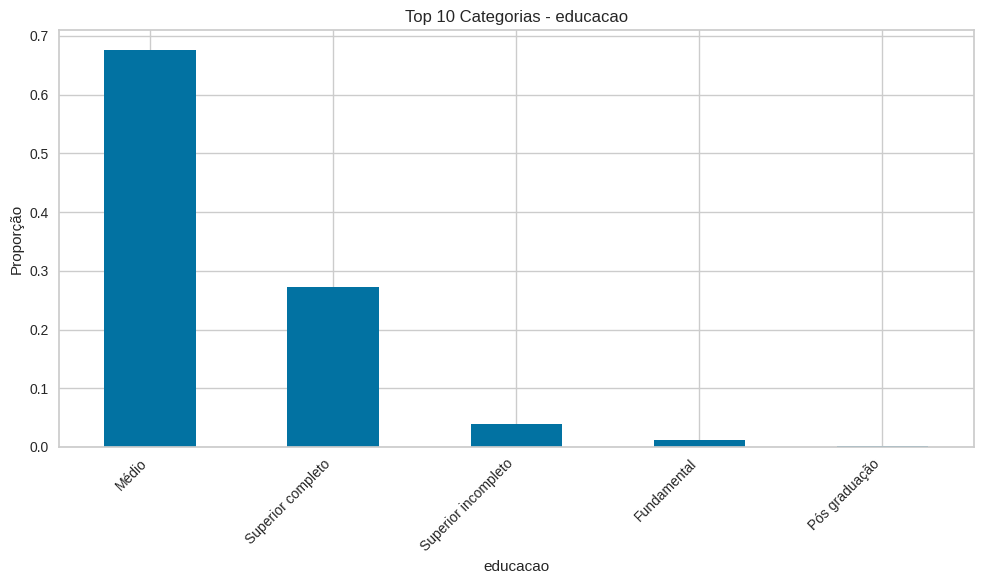


estado_civil:
estado_civil
Casado      0.701963
Solteiro    0.122212
União       0.076913
Separado    0.056761
Viúvo       0.042151
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


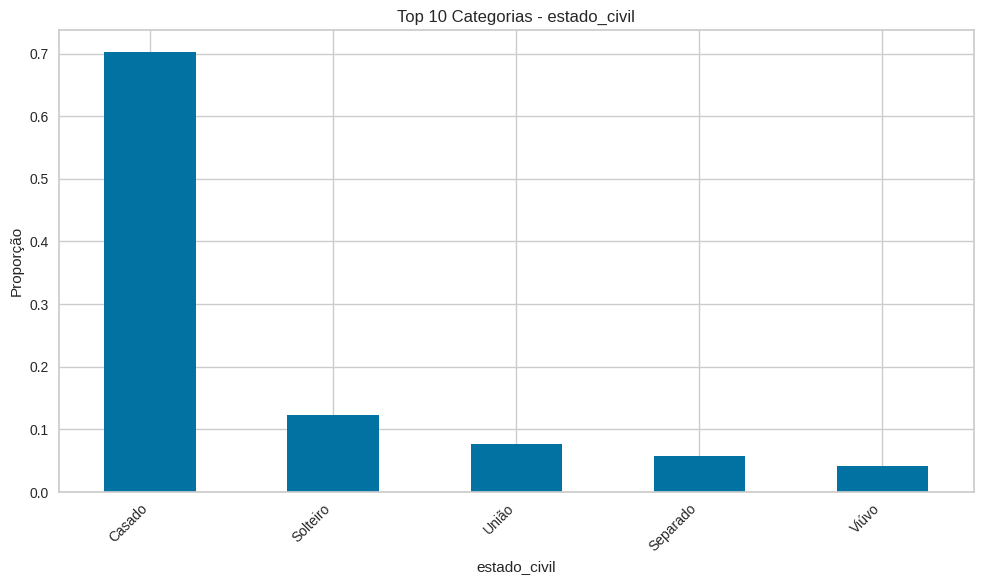


tipo_residencia:
tipo_residencia
Casa             0.899059
Com os pais      0.044309
Governamental    0.031253
Aluguel          0.013799
Estúdio          0.007193
Name: proportion, dtype: float64
Número de categorias únicas: 6
Percentual de valores missing: 0.00%


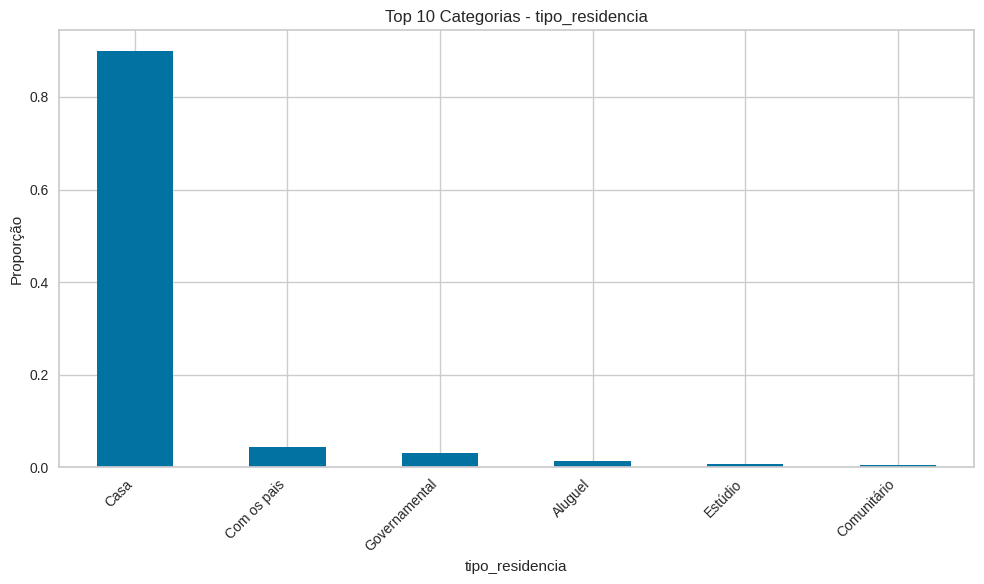

In [26]:
# Análise univariada para variáveis qualitativas
print("\nAnálise univariada para variáveis qualitativas:")
for col in variaveis_qualitativas:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True).head())
    print(f"Número de categorias únicas: {df[col].nunique()}")
    print(f"Percentual de valores missing: {df[col].isnull().mean()*100:.2f}%")

    # Plotar gráfico de barras para as 10 categorias mais frequentes
    plt.figure(figsize=(10, 6))
    df[col].value_counts(normalize=True).head(10).plot(kind='bar')
    plt.title(f'Top 10 Categorias - {col}')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Análise univariada para variáveis quantitativas:

qtd_filhos:
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 68.98%


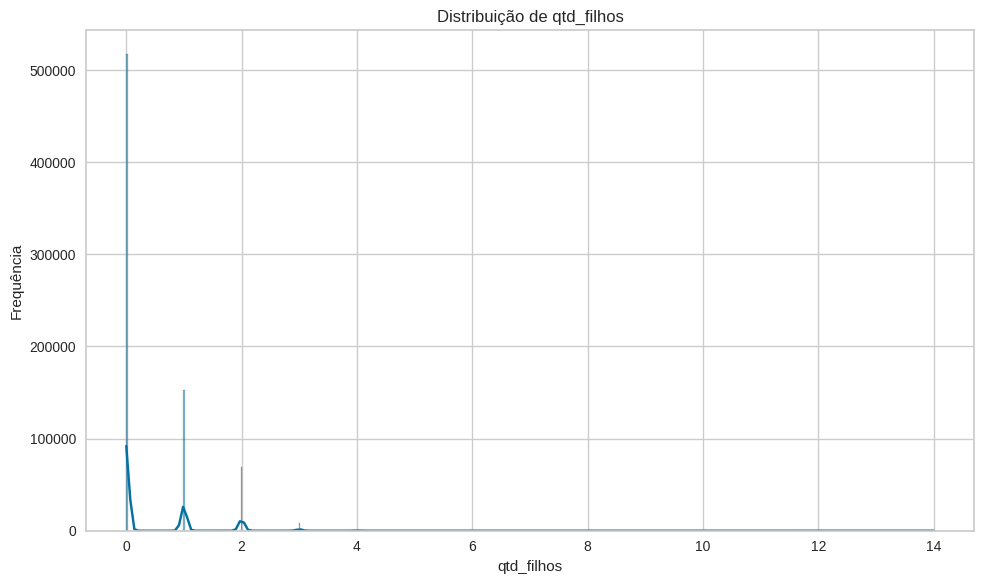


idade:
count    750000.000000
mean         43.804733
std          11.229868
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 0.00%


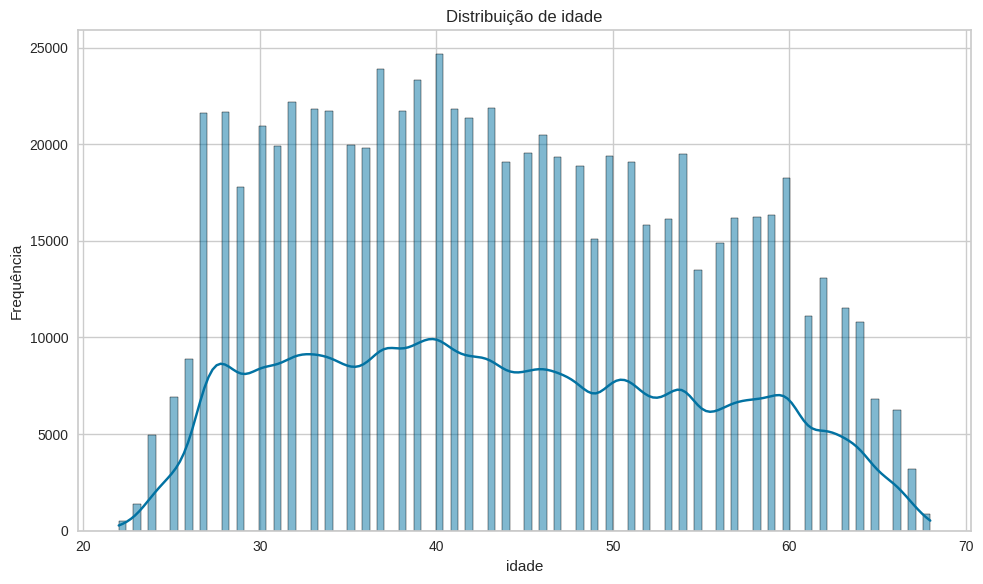


tempo_emprego:
count    624043.000000
mean          7.748574
std           6.687455
min           0.117808
25%           3.049315
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64
Percentual de valores missing: 16.79%
Percentual de zeros: 0.00%


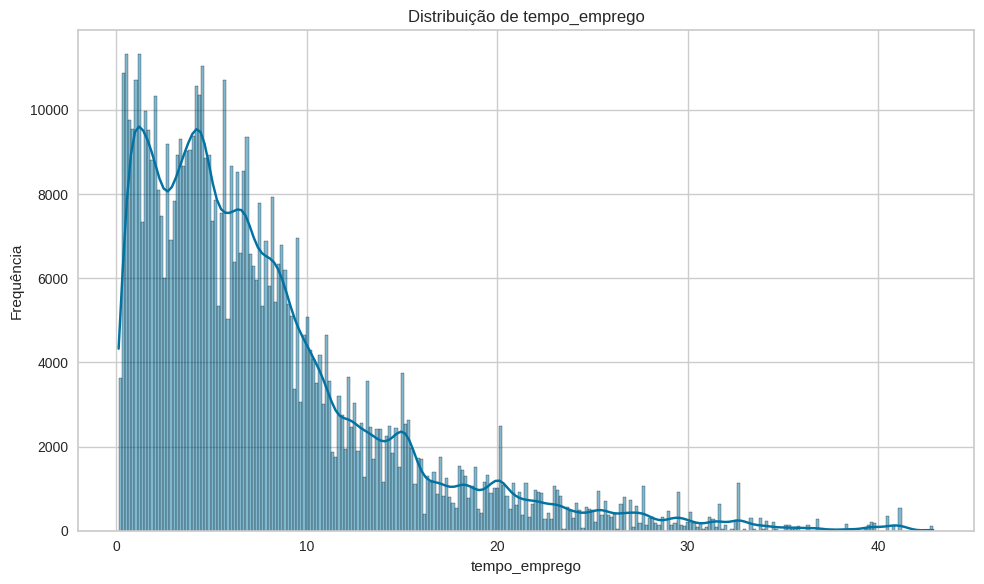


qt_pessoas_residencia:
count    750000.000000
mean          2.212241
std           0.903428
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 0.00%


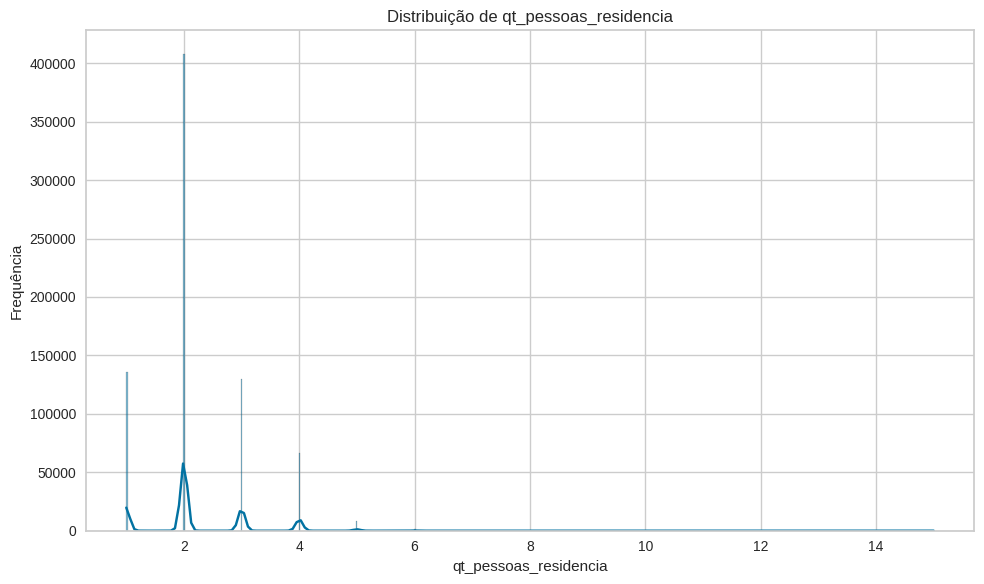


renda:
count    7.500000e+05
mean     2.323854e+04
std      7.910601e+04
min      1.076700e+02
25%      3.467700e+03
50%      7.861820e+03
75%      1.831828e+04
max      4.083986e+06
Name: renda, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 0.00%


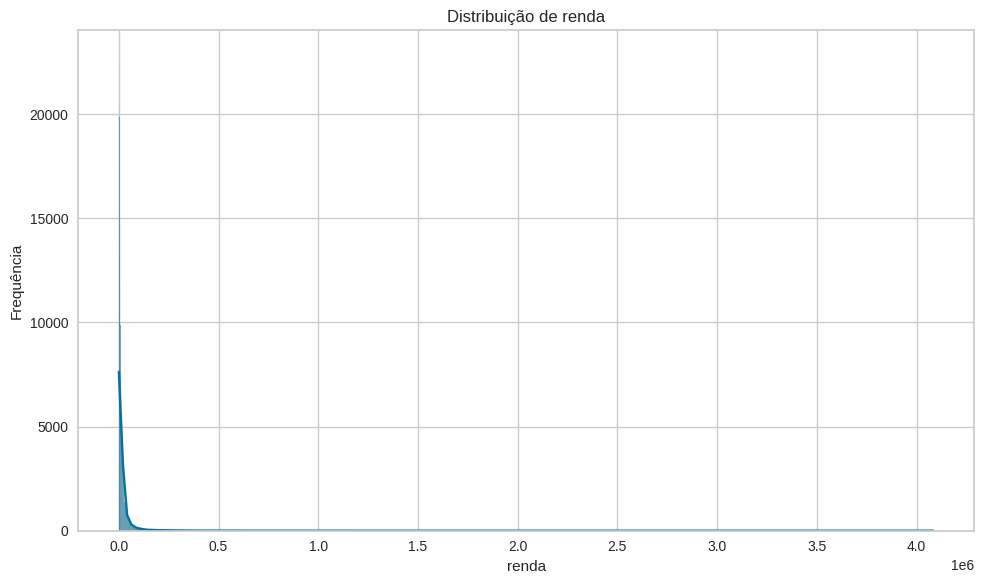

In [27]:
# Análise univariada para variáveis quantitativas
print("\nAnálise univariada para variáveis quantitativas:")
for col in variaveis_quantitativas:
    print(f"\n{col}:")
    print(df[col].describe())
    print(f"Percentual de valores missing: {df[col].isnull().mean()*100:.2f}%")
    print(f"Percentual de zeros: {(df[col] == 0).mean()*100:.2f}%")

    # Plotar histograma
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()


Distribuição da variável alvo (inadimplente):
idade
40    0.032884
37    0.031832
39    0.031079
32    0.029549
43    0.029161
41    0.029115
33    0.029112
38    0.028963
34    0.028960
28    0.028861
27    0.028799
42    0.028489
30    0.027901
46    0.027313
35    0.026627
31    0.026575
36    0.026381
45    0.026092
54    0.026023
50    0.025868
47    0.025795
51    0.025451
44    0.025424
48    0.025160
60    0.024367
29    0.023733
59    0.021797
58    0.021648
57    0.021563
53    0.021493
52    0.021113
49    0.020115
56    0.019844
55    0.017977
62    0.017447
63    0.015347
61    0.014787
64    0.014401
26    0.011855
25    0.009215
65    0.009056
66    0.008296
24    0.006599
67    0.004265
23    0.001869
68    0.001140
22    0.000660
Name: proportion, dtype: float64


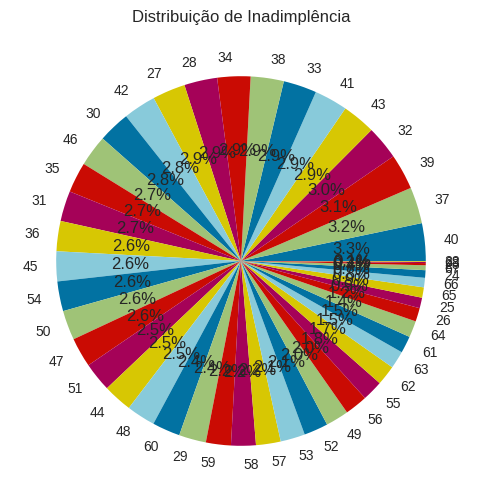

In [28]:
# Análise da variável alvo (inadimplente)
print("\nDistribuição da variável alvo (inadimplente):")
print(df['idade'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
df['idade'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de Inadimplência')
plt.ylabel('')
plt.show()

In [29]:
# Identificar variáveis qualitativas e quantitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'category']).columns
variaveis_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns
variaveis_quantitativas = [col for col in variaveis_quantitativas if col not in ['index', 'inadimplente']]

In [30]:
# Função para calcular IV (Information Value)
def calculate_iv(df, feature, target):
    df_woe = pd.DataFrame({'feature_value': df[feature].value_counts().index}) # Create DataFrame with just feature values
    df_woe['good'] = df[df[target] == 0][feature].value_counts()
    df_woe['bad'] = df[df[target] == 1][feature].value_counts()
    df_woe = df_woe.fillna(0.5) # Fill NaN values after creating the DataFrame
    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['woe'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    df_woe['iv'] = (df_woe['good_rate'] - df_woe['bad_rate']) * df_woe['woe']
    return df_woe['iv'].sum()

In [31]:
# Nans = A 0
df.fillna(0, inplace=True)

Análise bivariada para variáveis qualitativas:

sexo:
idade        22        23        24        25        26        27        28  \
sexo                                                                          
F      0.000640  0.001060  0.002870  0.005718  0.009148  0.022335  0.020748   
M      0.000701  0.003533  0.014265  0.016405  0.017419  0.042087  0.045542   

idade        29        30        31  ...        59        60        61  \
sexo                                 ...                                 
F      0.019002  0.026630  0.021893  ...  0.026359  0.029876  0.019472   
M      0.033461  0.030515  0.036199  ...  0.012420  0.013039  0.005154   

idade        62        63        64        65        66        67       68  
sexo                                                                        
F      0.022080  0.017809  0.016420  0.012597  0.009826  0.004358  0.00133  
M      0.007921  0.010284  0.010252  0.001777  0.005150  0.004075  0.00075  

[2 rows x 47 columns]
Q

<Figure size 1200x600 with 0 Axes>

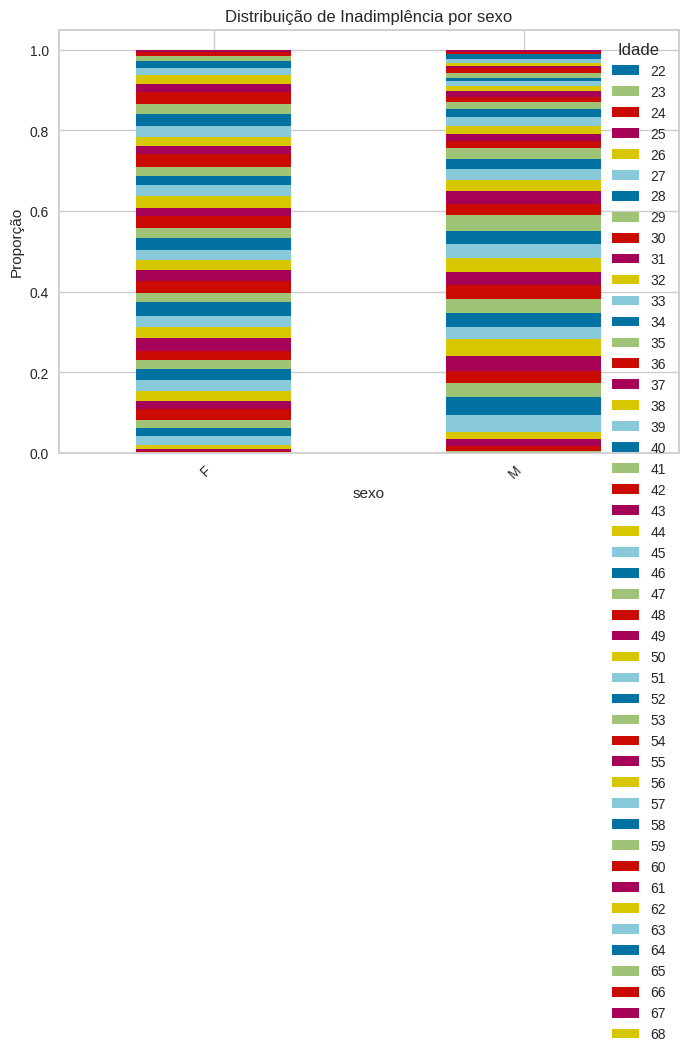


posse_de_veiculo:
idade                   22        23        24        25        26        27  \
posse_de_veiculo                                                               
N                 0.001081  0.001391  0.005107  0.008693  0.010922  0.028328   
S                 0.000000  0.002619  0.008937  0.010033  0.013316  0.029536   

idade                   28        29        30        31  ...        59  \
posse_de_veiculo                                          ...             
N                 0.025129  0.020142  0.026007  0.018342  ...  0.025072   
S                 0.034714  0.029365  0.030872  0.039484  ...  0.016662   

idade                   60        61        62        63        64       65  \
posse_de_veiculo                                                              
N                 0.030774  0.020915  0.022013  0.019441  0.016862  0.01242   
S                 0.014320  0.005177  0.010286  0.008927  0.010543  0.00378   

idade                   66        67      

<Figure size 1200x600 with 0 Axes>

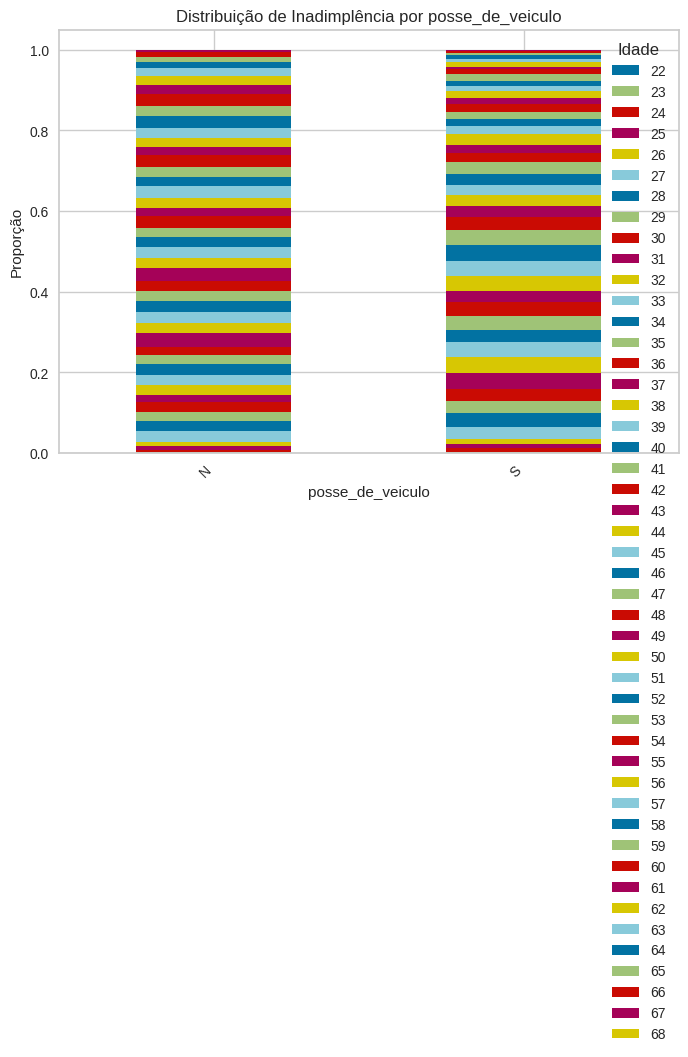


posse_de_imovel:
idade                  22        23        24        25        26        27  \
posse_de_imovel                                                               
N                0.000390  0.002643  0.011238  0.013309  0.017027  0.035821   
S                0.000792  0.001491  0.004330  0.007213  0.009325  0.025365   

idade                  28        29        30        31  ...        59  \
posse_de_imovel                                          ...             
N                0.036937  0.024534  0.036954  0.028704  ...  0.015891   
S                0.024912  0.023342  0.023475  0.025533  ...  0.024686   

idade                  60        61        62        63        64        65  \
posse_de_imovel                                                               
N                0.014429  0.007239  0.014750  0.010605  0.007068  0.006780   
S                0.029226  0.018478  0.018765  0.017666  0.017987  0.010169   

idade                  66        67        68  
pos

<Figure size 1200x600 with 0 Axes>

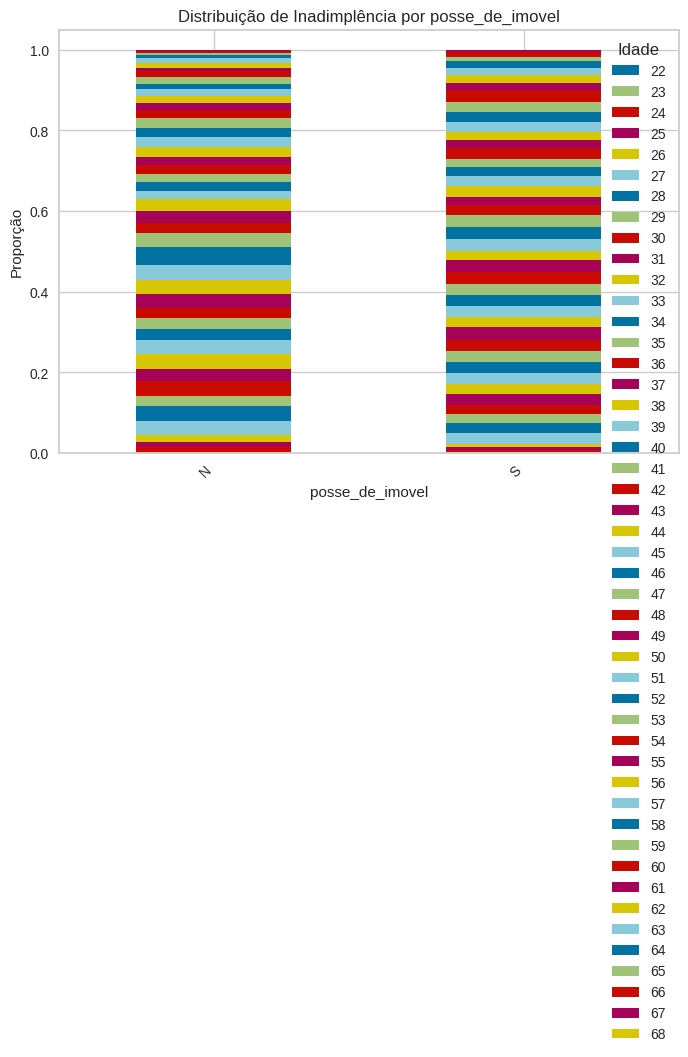


tipo_renda:
idade                   22        23        24        25        26        27  \
tipo_renda                                                                     
Assalariado       0.000946  0.002183  0.007427  0.009221  0.012638  0.033621   
Bolsista          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Empresário        0.000753  0.001158  0.009235  0.015251  0.018719  0.037681   
Pensionista       0.000000  0.000000  0.000000  0.000000  0.000333  0.002123   
Servidor público  0.000000  0.005545  0.007532  0.011090  0.011414  0.028557   

idade                   28        29        30        31  ...        59  \
tipo_renda                                                ...             
Assalariado       0.033740  0.027609  0.030821  0.034072  ...  0.010530   
Bolsista          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
Empresário        0.038648  0.032215  0.035284  0.029610  ...  0.007046   
Pensionista       0.000689  0.000000  0.000000  0.0

<Figure size 1200x600 with 0 Axes>

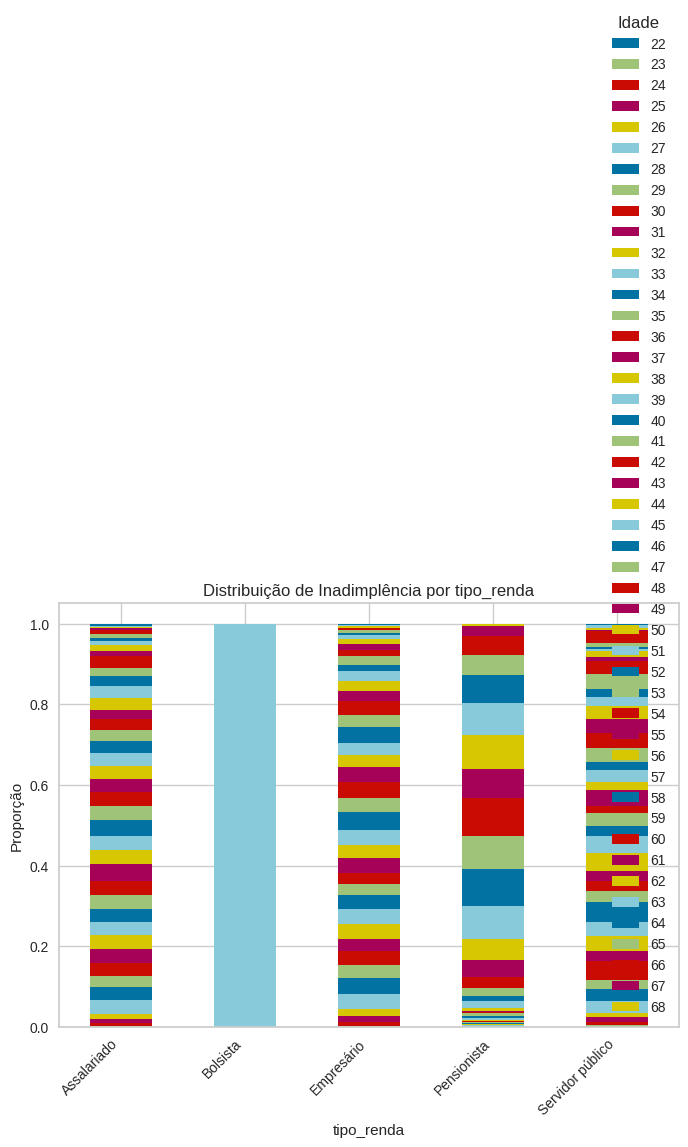


educacao:
idade                      22        23        24        25        26  \
educacao                                                                
Fundamental          0.000000  0.000000  0.000000  0.000000  0.011079   
Médio                0.000377  0.002162  0.004777  0.006053  0.008241   
Pós graduação        0.000000  0.000000  0.000000  0.000000  0.000000   
Superior completo    0.000563  0.000455  0.006691  0.012848  0.016764   
Superior incompleto  0.006413  0.007227  0.039395  0.041329  0.040514   

idade                      27        28        29        30        31  ...  \
educacao                                                               ...   
Fundamental          0.037551  0.055510  0.030671  0.004665  0.005364  ...   
Médio                0.022583  0.024087  0.017659  0.019971  0.019253  ...   
Pós graduação        0.000000  0.000000  0.000000  0.000000  0.000000  ...   
Superior completo    0.039617  0.036543  0.033367  0.046587  0.037620  ...   
Superior 

<Figure size 1200x600 with 0 Axes>

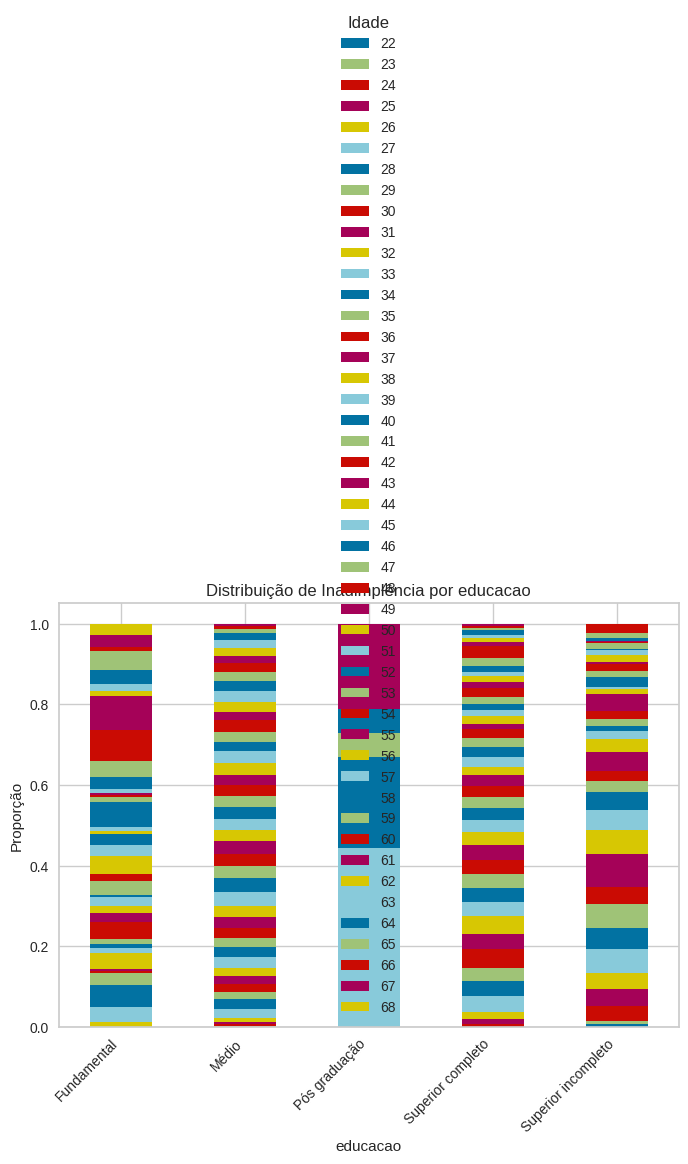


estado_civil:
idade               22        23        24        25        26        27  \
estado_civil                                                               
Casado        0.000283  0.000948  0.004828  0.005814  0.010058  0.027656   
Separado      0.001010  0.000000  0.000000  0.000000  0.005356  0.005356   
Solteiro      0.002335  0.009852  0.020380  0.031704  0.029130  0.058979   
União         0.001543  0.000000  0.009344  0.016365  0.012100  0.024356   
Viúvo         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

idade               28        29        30        31  ...        59        60  \
estado_civil                                          ...                       
Casado        0.029696  0.023095  0.032275  0.029187  ...  0.019729  0.019291   
Separado      0.012755  0.024218  0.007258  0.006812  ...  0.053205  0.016514   
Solteiro      0.044327  0.034988  0.017456  0.027788  ...  0.013245  0.035479   
União         0.022536  0.023698  0.035104  0.0

<Figure size 1200x600 with 0 Axes>

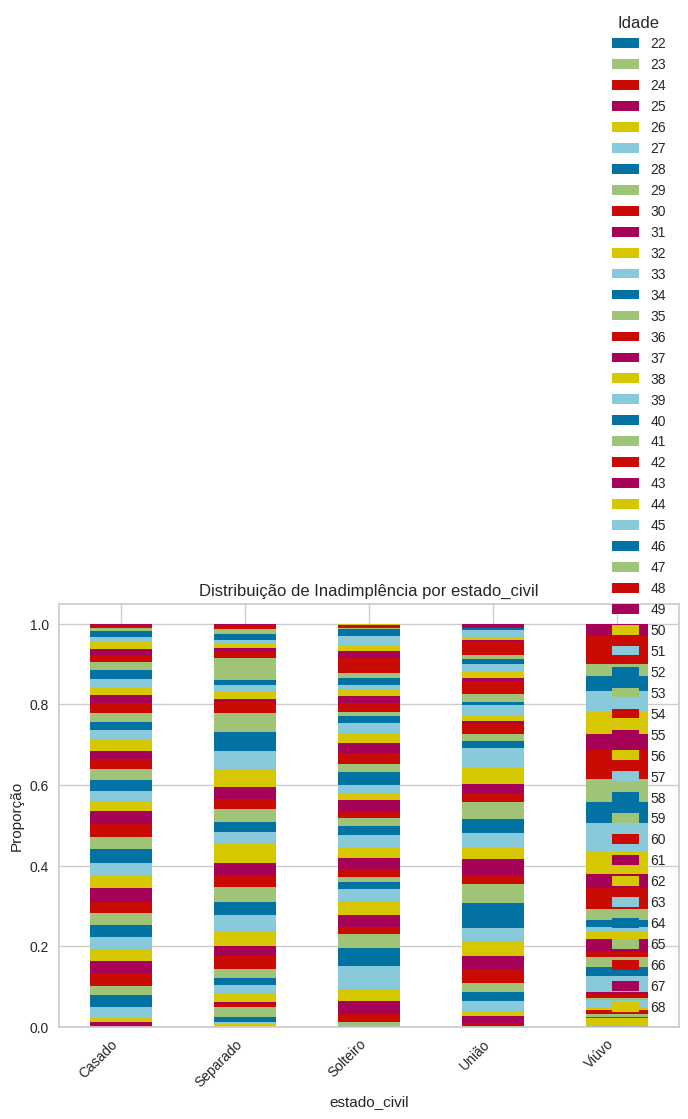


tipo_residencia:
idade                  22        23        24        25        26        27  \
tipo_residencia                                                               
Aluguel          0.013045  0.004348  0.004348  0.012948  0.044932  0.051696   
Casa             0.000257  0.001487  0.004551  0.008519  0.010565  0.027314   
Com os pais      0.004032  0.003822  0.044957  0.027112  0.029670  0.067826   
Comunitário      0.016109  0.000000  0.000000  0.000000  0.000000  0.031915   
Estúdio          0.000000  0.000000  0.000000  0.007970  0.024467  0.018350   
Governamental    0.000000  0.009684  0.014548  0.003797  0.007850  0.008020   

idade                  28        29        30        31  ...        59  \
tipo_residencia                                          ...             
Aluguel          0.055078  0.056624  0.017296  0.053435  ...  0.008890   
Casa             0.026506  0.021710  0.025886  0.025622  ...  0.022935   
Com os pais      0.081668  0.060424  0.070595  0.0416

<Figure size 1200x600 with 0 Axes>

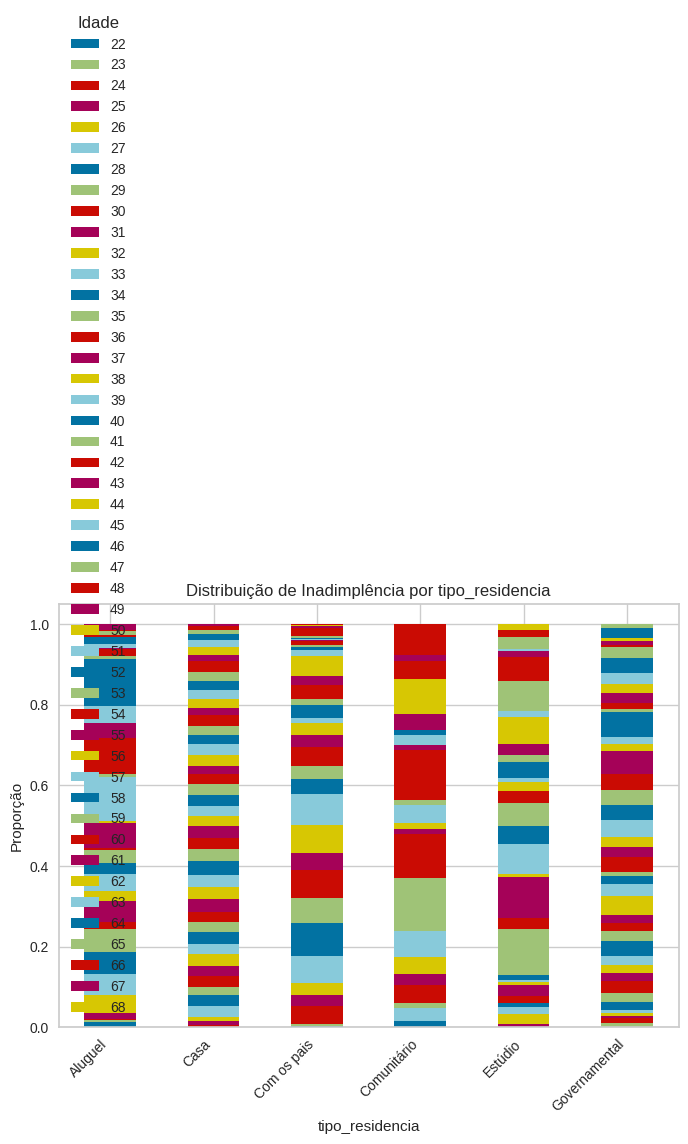

In [32]:
# Análise bivariada para variáveis qualitativas
print("Análise bivariada para variáveis qualitativas:")
for col in variaveis_qualitativas:
    print(f"\n{col}:")

    # Tabela de contingência
    cont_table = pd.crosstab(df[col], df['idade'], normalize='index')
    print(cont_table)

    # Teste qui-quadrado
    chi2, p_value = stats.chi2_contingency(pd.crosstab(df[col], df['idade']))[:2]
    print(f"Qui-quadrado: {chi2:.4f}, p-value: {p_value:.4f}")

    # Information Value
    iv = calculate_iv(df, col, 'idade')
    print(f"Information Value: {iv:.4f}")

    # Gráfico de barras empilhadas
    plt.figure(figsize=(12, 6))
    cont_table.plot(kind='bar', stacked=True)
    plt.title(f'Distribuição de Inadimplência por {col}')
    plt.xlabel(col)
    plt.ylabel('Proporção')
    plt.legend(title='Idade')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Análise bivariada para variáveis quantitativas:

qtd_filhos:
         count      mean       std  min  25%  50%  75%   max
idade                                                       
22       495.0  0.177778  0.382712  0.0  0.0  0.0  0.0   1.0
23      1402.0  0.189016  0.391661  0.0  0.0  0.0  0.0   1.0
24      4949.0  0.204486  0.427212  0.0  0.0  0.0  0.0   2.0
25      6911.0  0.219795  0.428563  0.0  0.0  0.0  0.0   2.0
26      8891.0  0.468789  0.665398  0.0  0.0  0.0  1.0   2.0
27     21599.0  0.538266  0.755574  0.0  0.0  0.0  1.0   3.0
28     21646.0  0.466922  0.633835  0.0  0.0  0.0  1.0   3.0
29     17800.0  0.676067  0.737470  0.0  0.0  1.0  1.0   3.0
30     20926.0  0.851429  0.811538  0.0  0.0  1.0  1.0   3.0
31     19931.0  0.910893  0.851366  0.0  0.0  1.0  1.0   5.0
32     22162.0  0.649806  0.788527  0.0  0.0  0.0  1.0   3.0
33     21834.0  0.710910  0.883319  0.0  0.0  0.0  1.0   3.0
34     21720.0  0.978085  0.833138  0.0  0.0  1.0  2.0   4.0
35     19970.0  0.89469

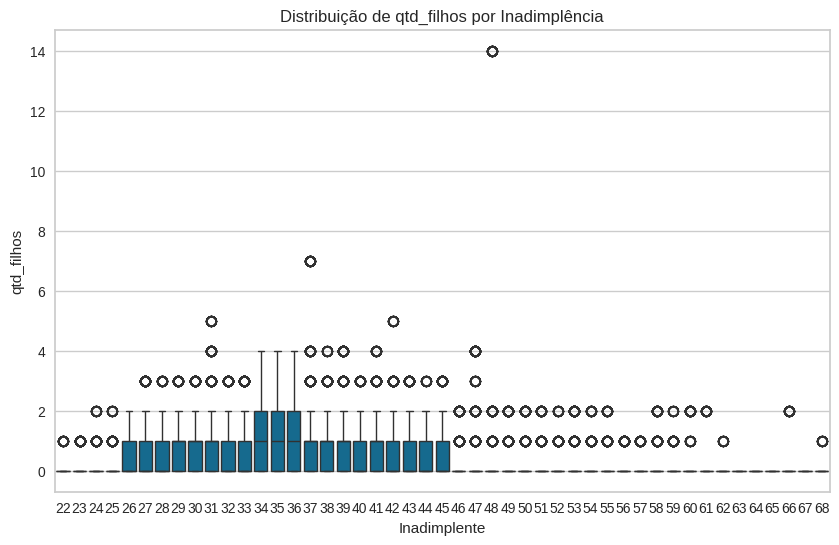

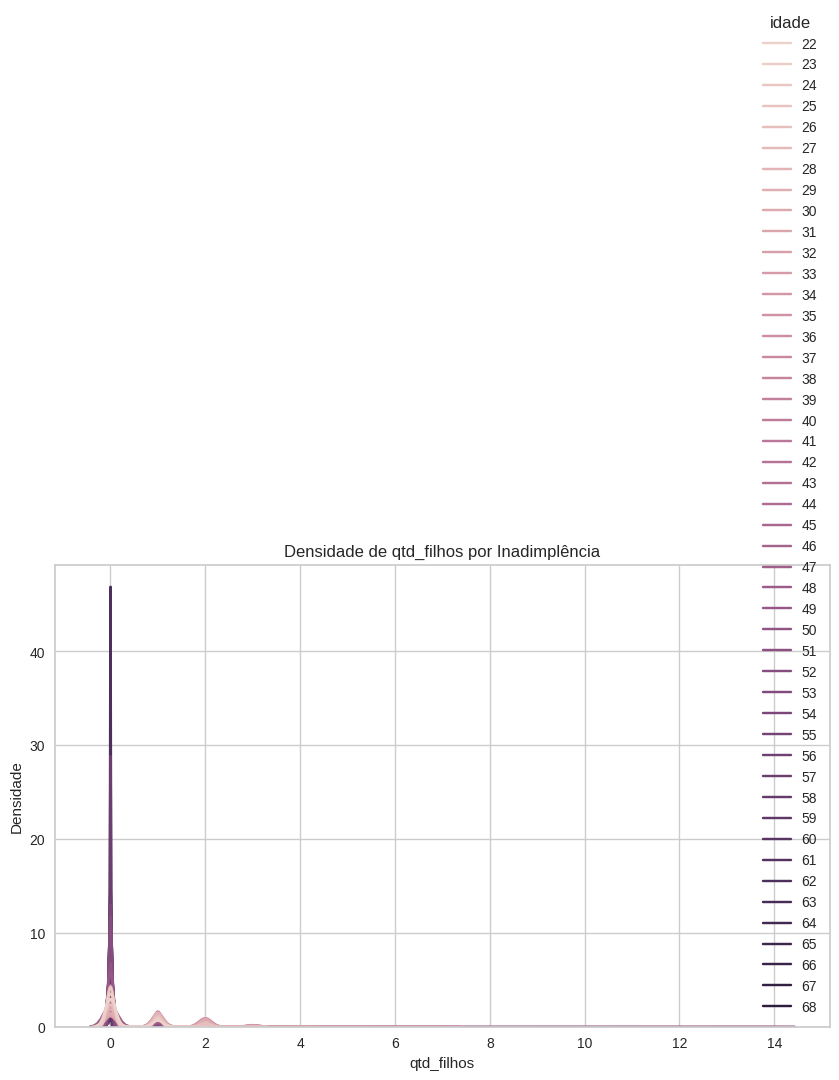


idade:
         count  mean  std   min   25%   50%   75%   max
idade                                                  
22       495.0  22.0  0.0  22.0  22.0  22.0  22.0  22.0
23      1402.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0
24      4949.0  24.0  0.0  24.0  24.0  24.0  24.0  24.0
25      6911.0  25.0  0.0  25.0  25.0  25.0  25.0  25.0
26      8891.0  26.0  0.0  26.0  26.0  26.0  26.0  26.0
27     21599.0  27.0  0.0  27.0  27.0  27.0  27.0  27.0
28     21646.0  28.0  0.0  28.0  28.0  28.0  28.0  28.0
29     17800.0  29.0  0.0  29.0  29.0  29.0  29.0  29.0
30     20926.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
31     19931.0  31.0  0.0  31.0  31.0  31.0  31.0  31.0
32     22162.0  32.0  0.0  32.0  32.0  32.0  32.0  32.0
33     21834.0  33.0  0.0  33.0  33.0  33.0  33.0  33.0
34     21720.0  34.0  0.0  34.0  34.0  34.0  34.0  34.0
35     19970.0  35.0  0.0  35.0  35.0  35.0  35.0  35.0
36     19786.0  36.0  0.0  36.0  36.0  36.0  36.0  36.0
37     23874.0  37.0  0.0  37.0  37.0  3

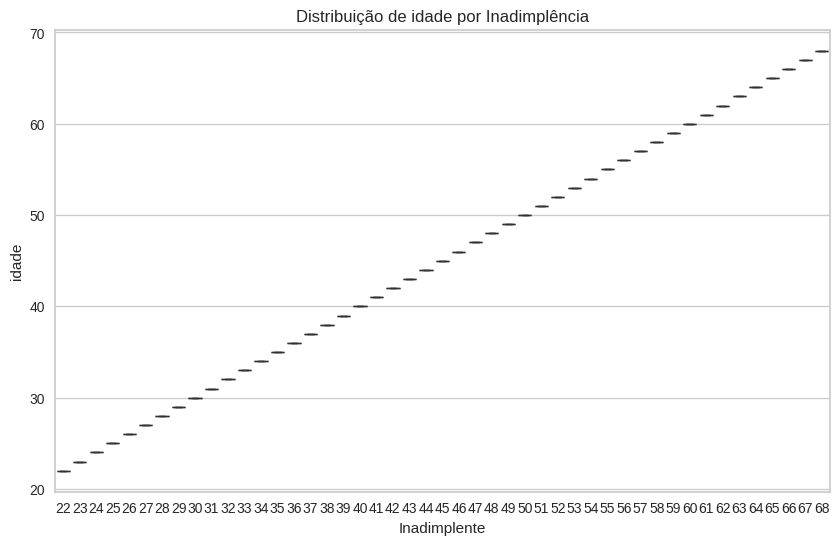

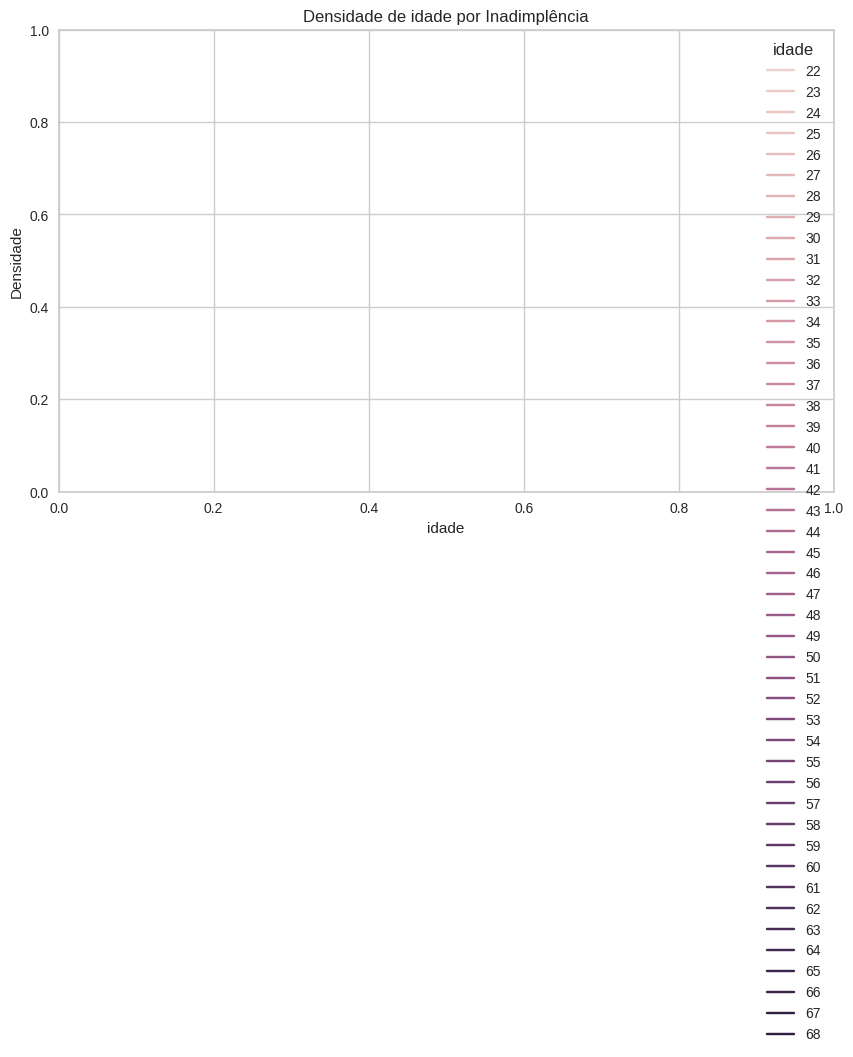


tempo_emprego:
         count       mean        std       min       25%       50%        75%  \
idade                                                                           
22       495.0   2.912257   1.249596  0.786301  1.846575  2.961644   4.378082   
23      1402.0   2.758152   1.550816  0.345205  0.964384  2.931507   4.210959   
24      4949.0   2.985212   1.785055  0.397260  1.641096  2.630137   4.424658   
25      6911.0   3.481569   1.683753  0.295890  2.542466  3.687671   4.693151   
26      8891.0   3.775504   2.488594  0.000000  1.624658  3.268493   5.778082   
27     21599.0   4.145640   2.443225  0.000000  1.838356  4.347945   5.769863   
28     21646.0   4.587275   2.721859  0.000000  2.013699  4.693151   6.676712   
29     17800.0   4.907844   2.691718  0.178082  3.021918  4.410959   6.792466   
30     20926.0   5.299218   3.231310  0.263014  2.345205  5.328767   7.624658   
31     19931.0   5.658062   3.535152  0.200000  2.375342  5.298630   8.298630   
32     22162

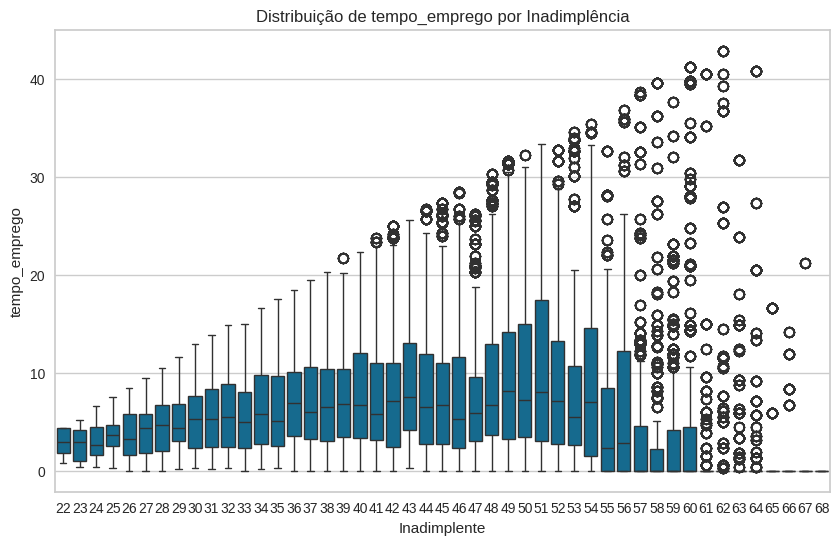

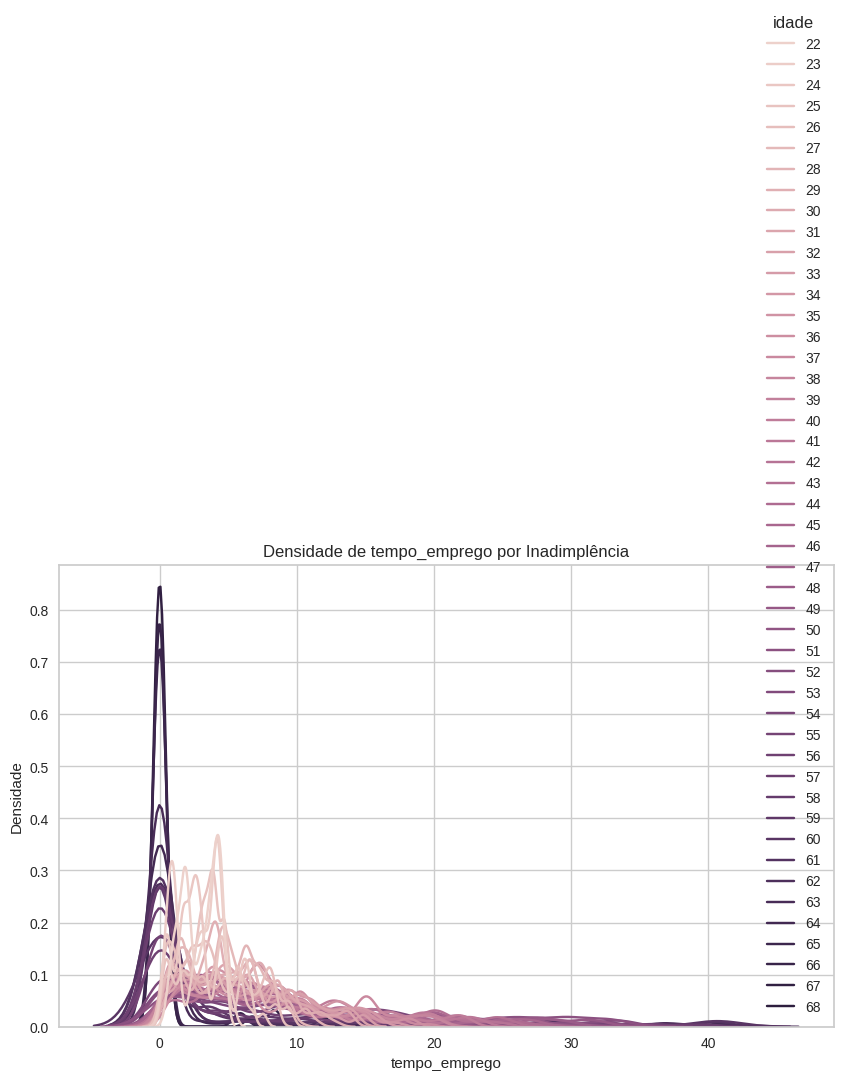


qt_pessoas_residencia:
         count      mean       std  min  25%  50%  75%   max
idade                                                       
22       495.0  1.658586  0.638351  1.0  1.0  2.0  2.0   3.0
23      1402.0  1.544936  0.791492  1.0  1.0  1.0  2.0   3.0
24      4949.0  1.827036  0.756265  1.0  1.0  2.0  2.0   4.0
25      6911.0  1.799305  0.764691  1.0  1.0  2.0  2.0   4.0
26      8891.0  2.142841  0.957863  1.0  1.0  2.0  3.0   4.0
27     21599.0  2.277420  0.953685  1.0  2.0  2.0  3.0   5.0
28     21646.0  2.249238  0.842407  1.0  2.0  2.0  3.0   5.0
29     17800.0  2.438371  0.952209  1.0  2.0  2.0  3.0   5.0
30     20926.0  2.762449  0.910844  1.0  2.0  3.0  3.0   5.0
31     19931.0  2.768552  0.980935  1.0  2.0  3.0  3.0   7.0
32     22162.0  2.431820  0.976311  1.0  2.0  2.0  3.0   5.0
33     21834.0  2.546533  1.018746  1.0  2.0  2.0  3.0   5.0
34     21720.0  2.858932  0.936734  1.0  2.0  3.0  4.0   6.0
35     19970.0  2.777967  0.997606  1.0  2.0  3.0  4.0   6.0


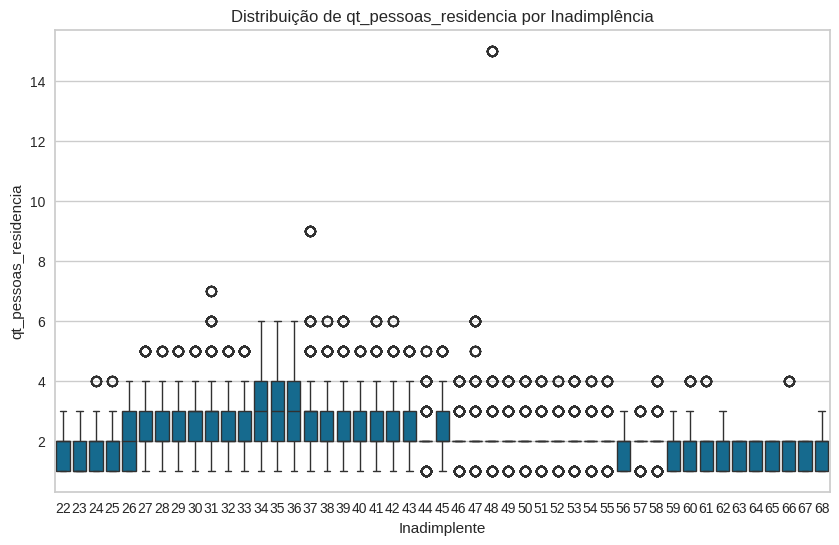

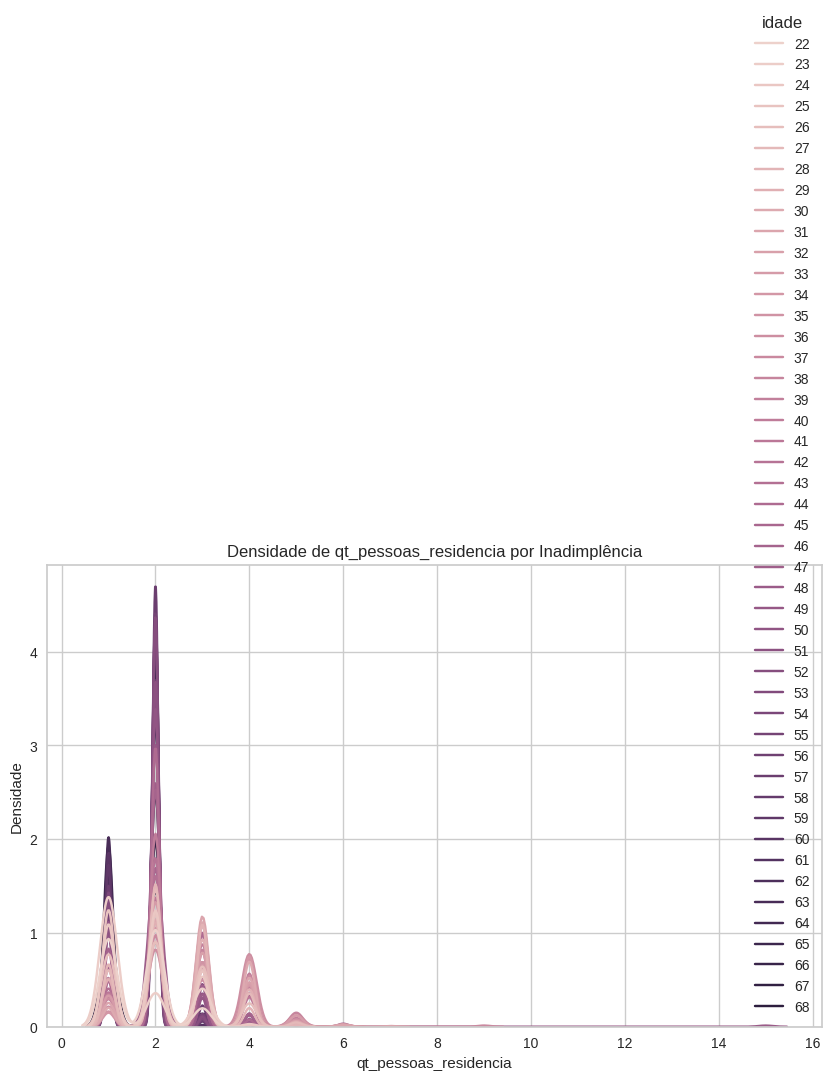


renda:
         count          mean            std     min        25%        50%  \
idade                                                                       
22       495.0   9967.618869    9484.204203  968.49  3604.5900   7197.620   
23      1402.0   6362.218645    6743.200010  297.47  2017.1900   3812.970   
24      4949.0   6833.295516    8056.516328  193.82  2040.7300   4128.100   
25      6911.0   8225.515248    9592.551963  233.24  2344.2700   5056.230   
26      8891.0   8079.862640    9262.169974  156.62  2374.9400   5025.500   
27     21599.0   8742.638321   11500.289302  123.69  2455.5400   5088.930   
28     21646.0  10148.809976   13336.305559  232.17  2770.9000   5842.220   
29     17800.0  10341.961679   13268.946890  209.04  2950.2500   6086.230   
30     20926.0  10656.649106   14138.372080  184.47  2919.9650   6115.925   
31     19931.0  11934.975051   16992.396567  113.36  2944.6450   6365.670   
32     22162.0  12630.296554   16474.713200  183.85  3387.0400   719

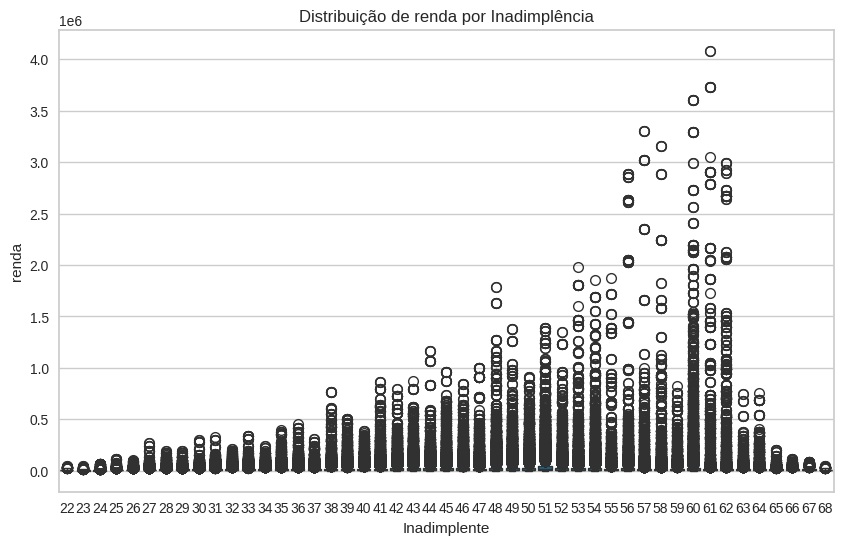

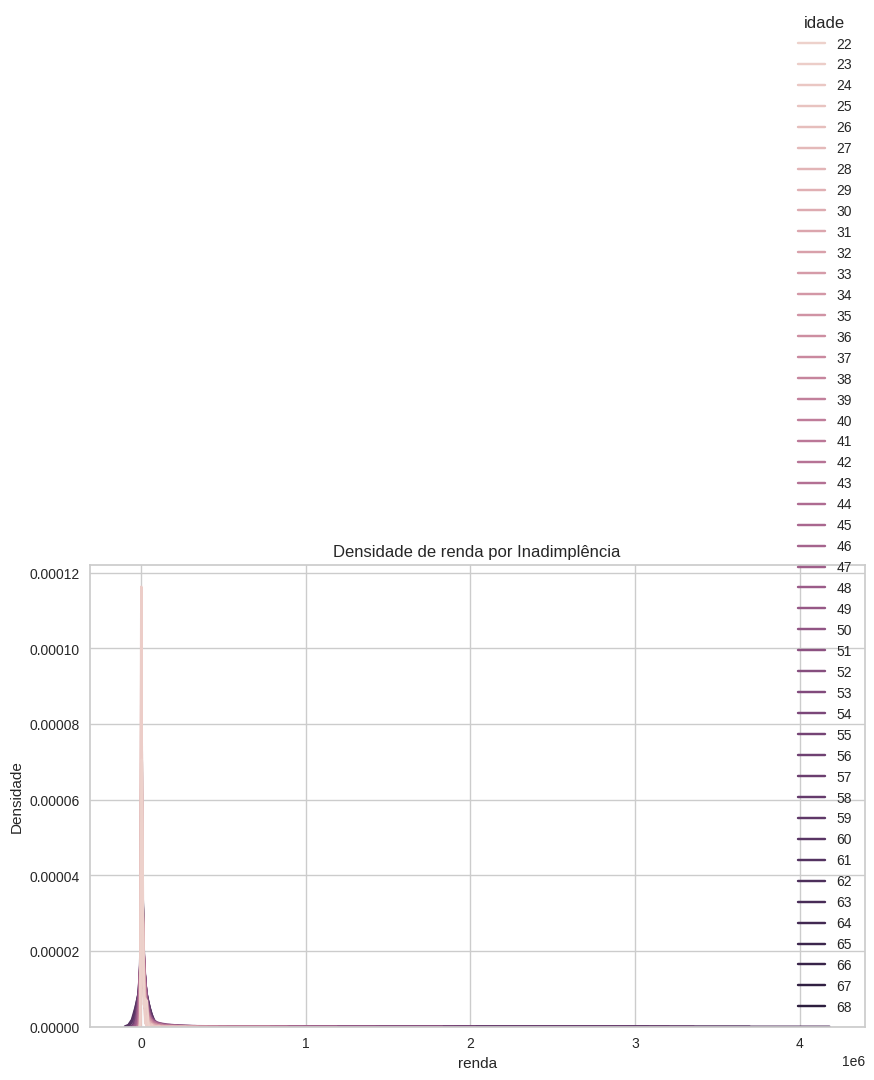

In [33]:
# Análise bivariada para variáveis quantitativas
print("\nAnálise bivariada para variáveis quantitativas:")
for col in variaveis_quantitativas:
    print(f"\n{col}:")

    # Estatísticas descritivas por grupo
    print(df.groupby('idade')[col].describe())

    # Teste t
    t_stat, p_value = stats.ttest_ind(df[df['idade'] == 0][col].dropna(),
                                      df[df['idade'] == 1][col].dropna())
    print(f"Teste t: t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

    # Correlação ponto-bisserial
    corr, _ = stats.pointbiserialr(df['idade'], df[col])
    print(f"Correlação ponto-bisserial: {corr:.4f}")

    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='idade', y=col, data=df)
    plt.title(f'Distribuição de {col} por Inadimplência')
    plt.xlabel('Inadimplente')
    plt.ylabel(col)
    plt.show()

    # KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=col, hue='idade', common_norm=False)
    plt.title(f'Densidade de {col} por Inadimplência')
    plt.xlabel(col)
    plt.ylabel('Densidade')
    plt.show()

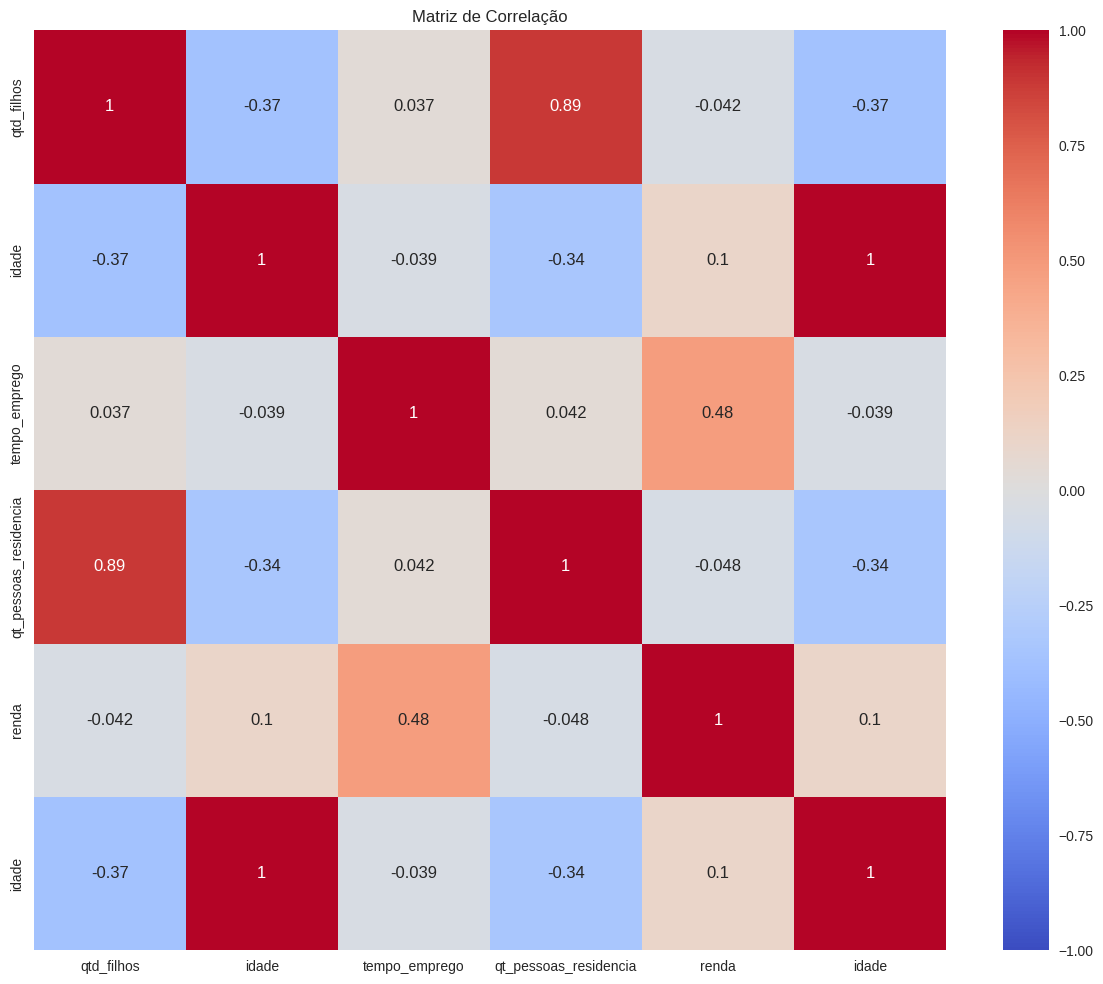

In [34]:
# Matriz de correlação para variáveis quantitativas
corr_matrix = df[variaveis_quantitativas + ['idade']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

In [35]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [36]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'index']
# Check if columns exist before dropping
df_dev = df_dev.drop(columns=colunas_para_remover, errors='ignore')
df_oot = df_oot.drop(columns=colunas_para_remover, errors='ignore')

In [37]:
# Função para tratar outliers
def tratar_outliers(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    return serie.clip(limite_inferior, limite_superior)

In [38]:
# Função para agrupar categorias raras
def agrupar_categorias_raras(serie, threshold=0.05):
    contagem = serie.value_counts(normalize=True)
    categorias_raras = contagem[contagem < threshold].index
    return serie.replace(categorias_raras, 'Outros')

In [39]:
# Tratamento de valores missing, outliers e zeros estruturais
for col in df_dev.columns:
    if df_dev[col].dtype in ['int64', 'float64'] and col != 'inadimplente':
        # Tratar zeros estruturais
        if (df_dev[col] == 0).sum() / len(df_dev) > 0.1:  # Se mais de 10% são zeros
            df_dev[f'{col}_zero'] = (df_dev[col] == 0).astype(int)
            df_dev.loc[df_dev[col] == 0, col] = np.nan

        # Imputar valores missing com mediana
        df_dev[col] = df_dev[col].fillna(df_dev[col].median())

        # Tratar outliers
        df_dev[col] = tratar_outliers(df_dev[col])
    elif df_dev[col].dtype == 'object':
        # Agrupar categorias raras
        df_dev[col] = agrupar_categorias_raras(df_dev[col])

        # Tratar valores missing em variáveis categóricas
        df_dev[col] = df_dev[col].fillna('Desconhecido')

In [40]:
# Separar features e target
X = df_dev.drop('idade', axis=1)
y = df_dev['idade']

In [41]:
# One-hot encoding para variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

In [42]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Treinar o modelo de regressão logística
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

In [45]:
# Avaliar o modelo
y_pred_proba = model.predict_proba(X_test_scaled)
# The following line was changed. Removed [:, 1]
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC no conjunto de teste: {auc:.4f}")
print("\nClassification Report no conjunto de teste:")
print(classification_report(y_test, model.predict(X_test_scaled)))

AUC no conjunto de teste: 0.7965

Classification Report no conjunto de teste:
              precision    recall  f1-score   support

          22       0.31      0.25      0.27        81
          23       0.27      0.17      0.20       235
          24       0.13      0.10      0.12       827
          25       0.04      0.03      0.03      1108
          26       0.00      0.00      0.00      1445
          27       0.09      0.22      0.13      3474
          28       0.07      0.13      0.09      3469
          29       0.10      0.01      0.02      2837
          30       0.13      0.19      0.16      3358
          31       0.11      0.15      0.13      3127
          32       0.13      0.08      0.10      3495
          33       0.11      0.06      0.08      3515
          34       0.10      0.11      0.10      3522
          35       0.09      0.02      0.03      3249
          36       0.13      0.15      0.14      3202
          37       0.10      0.18      0.13      3864
   

In [46]:
# Avaliar no conjunto OOT
X_oot = df_oot.drop('idade', axis=1)
X_oot = pd.get_dummies(X_oot, drop_first=True)
X_oot = X_oot.reindex(columns=X.columns, fill_value=0)

# Imputar valores ausentes usando SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_oot_imputed = imputer.fit_transform(X_oot)

X_oot_scaled = scaler.transform(X_oot_imputed)
y_oot = df_oot['idade']

y_oot_pred_proba = model.predict_proba(X_oot_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"\nAUC no conjunto OOT: {auc:.4f}")
print("\nClassification Report no conjunto OOT:")
print(classification_report(y_oot, model.predict(X_oot_scaled)))


AUC no conjunto OOT: 0.7965

Classification Report no conjunto OOT:
              precision    recall  f1-score   support

          22       0.00      0.00      0.00        96
          23       0.36      0.24      0.29       270
          24       0.00      0.00      0.00       971
          25       0.11      0.04      0.06      1418
          26       0.00      0.00      0.00      1806
          27       0.08      0.26      0.12      4310
          28       0.07      0.06      0.06      4240
          29       0.06      0.00      0.00      3598
          30       0.05      0.03      0.03      4088
          31       0.00      0.00      0.00      3936
          32       0.09      0.06      0.07      4408
          33       0.01      0.01      0.01      4270
          34       0.00      0.00      0.00      4381
          35       0.00      0.00      0.00      4025
          36       0.09      0.25      0.13      3981
          37       0.00      0.00      0.00      4772
          38

In [47]:
# Usar statsmodels para obter p-valores
X_train_sm = sm.add_constant(X_train_scaled)

# Por exemplo, se y_train for contínuo, pode ser necessário limitá-lo:
y_train_binary = (y_train > y_train.mean()).astype(int)

# Verifique e descarte recursos com variação zero
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X_train_sm = selector.fit_transform(X_train_sm)

# Calcule e inspecione a matriz de correlação
corr_matrix = np.corrcoef(X_train_sm, rowvar=False)
print(corr_matrix) # Check for high correlation values (close to 1 or -1)


# Ajustar o modelo com potencialmente menos recursos
model_sm = sm.Logit(y_train_binary, X_train_sm)
results = model_sm.fit()
print(results.summary())

[[ 1.00000000e+00 -1.23079272e-02  6.24365281e-01 -1.15217567e-01
  -4.65326253e-02 -9.73863078e-02 -4.04516975e-02 -9.35797598e-03
  -7.25932611e-02  1.77485585e-02 -8.77714358e-02  1.57032785e-01
  -4.76323647e-02 -9.62010952e-03  4.36703516e-03  1.21911305e-02
  -3.84774963e-02 -1.33063374e-02 -4.60560425e-02]
 [-1.23079272e-02  1.00000000e+00 -2.51288957e-02  2.16020302e-03
   7.99726262e-01  1.57396762e-01  1.66946286e-01 -1.64511637e-02
   1.99355192e-02 -5.18347299e-03 -2.35468034e-01  5.50173019e-02
   1.28901628e-02  4.72562919e-02 -2.74305430e-01 -2.40008665e-01
  -4.35439613e-01  7.44407454e-02  1.77256348e-02]
 [ 6.24365281e-01 -2.51288957e-02  1.00000000e+00 -1.69765420e-01
  -4.08349395e-02 -3.06449343e-02 -1.10023262e-02  6.08139219e-02
   8.35870647e-03  6.38678522e-03 -1.14904121e-01  1.23042493e-01
  -2.94957783e-02  4.50309864e-02 -2.82744534e-03  8.81640853e-03
  -8.12434607e-03 -7.32668719e-03 -3.18009451e-02]
 [-1.15217567e-01  2.16020302e-03 -1.69765420e-01  1.00

In [48]:
# Criar equação preditiva
coef_dict = dict(zip(X.columns, model.coef_[0]))
intercept = model.intercept_[0]

print("\nEquação Preditiva para 'inadimplente':")
equation = f"log(odds) = {intercept:.4f}"
for feature, coef in coef_dict.items():
    if abs(coef) > 0.001:  # Mostrar apenas coeficientes significativos
        equation += f" + ({coef:.4f} * {feature})"
print(equation)


Equação Preditiva para 'inadimplente':
log(odds) = -5.4932 + (-1.5502 * tempo_emprego) + (-0.1696 * qt_pessoas_residencia) + (0.2045 * renda) + (-0.0413 * mau) + (0.6162 * qtd_filhos_zero_zero) + (-0.0107 * sexo_M) + (-1.9623 * posse_de_veiculo_S) + (0.6117 * posse_de_imovel_S) + (-0.1245 * tipo_renda_Empresário) + (0.0822 * tipo_renda_Outros) + (-0.4915 * tipo_renda_Pensionista) + (-0.9801 * tipo_renda_Servidor público) + (0.6807 * educacao_Outros) + (0.2871 * educacao_Superior completo) + (-0.1057 * estado_civil_Outros) + (0.2743 * estado_civil_Separado) + (0.3530 * estado_civil_Solteiro) + (0.3549 * estado_civil_União) + (0.9992 * tipo_residencia_Outros)


In [49]:
# Identificar categorias não significantes
print("\nCategorias não significantes (p-valor > 0.05):")
for feature, p_value in zip(X.columns, results.pvalues[1:]):
    if p_value > 0.05:
        print(f"{feature}: p-valor = {p_value:.4f}")


Categorias não significantes (p-valor > 0.05):
qt_pessoas_residencia: p-valor = 0.1436


In [50]:
# Definindo colunas numéricas e categóricas
colunas_numericas = ['idade', 'salario']
colunas_categoricas = ['cidade']

In [51]:
# Construção de transformadores para colunas numéricas e categóricas
transformador_numerico = Pipeline(steps=[
    ('imputacao', SimpleImputer(strategy='mean')),  # Imputa valores faltantes com a média
    ('escalonamento', StandardScaler())  # Escalona (padroniza) os dados numéricos
])

In [52]:
transformador_categorico = Pipeline(steps=[
    ('imputacao', SimpleImputer(strategy='most_frequent')),  # Imputa valores faltantes com o mais frequente
    ('codificacao', OneHotEncoder(handle_unknown='ignore'))  # Codifica variáveis categóricas
])


In [53]:
# Aplicando os transformadores ao conjunto de dados
preprocessador = ColumnTransformer(transformers=[
    ('numerico', transformador_numerico, colunas_numericas),
    ('categorico', transformador_categorico, colunas_categoricas)
])

In [54]:
# Construindo o Pipeline completo (transformação + modelo)
pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessador),  # Aplica as transformações
    ('modelo', LogisticRegression())  # Treina um modelo de regressão logística
])

In [55]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
df['idade'] = 0
df['salario'] = 0
df['cidade'] = 0

In [57]:
# Converter apenas colunas numéricas em inteiros
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(f"Column {col} não foi possível converter para o tipo numérico.")

Column sexo não foi possível converter para o tipo numérico.
Column posse_de_veiculo não foi possível converter para o tipo numérico.
Column posse_de_imovel não foi possível converter para o tipo numérico.
Column tipo_renda não foi possível converter para o tipo numérico.
Column educacao não foi possível converter para o tipo numérico.
Column estado_civil não foi possível converter para o tipo numérico.
Column tipo_residencia não foi possível converter para o tipo numérico.


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  int64  
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          750000 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
 14  mau                    750000 non-nu

In [59]:
print(X_train.columns)

Index(['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau',
       'qtd_filhos_zero', 'qtd_filhos_zero_zero', 'sexo_M',
       'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Empresário',
       'tipo_renda_Outros', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor público', 'educacao_Outros',
       'educacao_Superior completo', 'estado_civil_Outros',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'tipo_residencia_Outros'],
      dtype='object')


In [60]:
print(X_test.columns)

Index(['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau',
       'qtd_filhos_zero', 'qtd_filhos_zero_zero', 'sexo_M',
       'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Empresário',
       'tipo_renda_Outros', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor público', 'educacao_Outros',
       'educacao_Superior completo', 'estado_civil_Outros',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'tipo_residencia_Outros'],
      dtype='object')


In [61]:
# Altere a coluna problemática para um tipo numérico, tratando de erros
df['sexo'] = pd.to_numeric(df['sexo'], errors='coerce')
df['posse_de_veiculo'] = pd.to_numeric(df['posse_de_veiculo'], errors='coerce')
df['posse_de_imovel'] = pd.to_numeric(df['posse_de_imovel'], errors='coerce')
df['tipo_renda'] = pd.to_numeric(df['tipo_renda'], errors='coerce')
df['educacao'] = pd.to_numeric(df['educacao'], errors='coerce')
df['estado_civil'] = pd.to_numeric(df['estado_civil'], errors='coerce')
df['tipo_residencia'] = pd.to_numeric(df['tipo_residencia'], errors='coerce')

In [63]:
# Nans = A 0
df.fillna(0, inplace=True)

In [64]:
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('estimator', LinearRegression()) # Use a regression model
])

def preprocess_data(df):

    # Divida os dados em conjuntos de treinamento e teste (exemplo)
    X = df.drop('renda', axis=1)
    y = df['renda']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

# Supondo que df seja seu DataFrame original
X_train, X_test, y_train, y_test = preprocess_data(df)

# Agora você pode ajustar o pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('estimator', LinearRegression())])

In [65]:
# Ajustando o pipeline aos dados de treino
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('estimator', LinearRegression())])

In [66]:
# Fazendo previsões nos dados de teste
y_pred = pipeline.predict(X_test)

Erro Quadrático Médio (MSE): 5029871289.83
R-quadrado (R2): 0.22
Erro Absoluto Médio (MAE): 26300.34

Interpretação:
- MSE: 5029871289.83 indica a média dos erros quadráticos. Valores menores indicam melhor ajuste.
- R-quadrado: 0.22 representa a proporção da variância dos dados explicada pelo modelo. Valores mais próximos de 1 indicam melhor ajuste.
- MAE: 26300.34 indica o erro absoluto médio, fornecendo uma medida da magnitude típica dos erros.


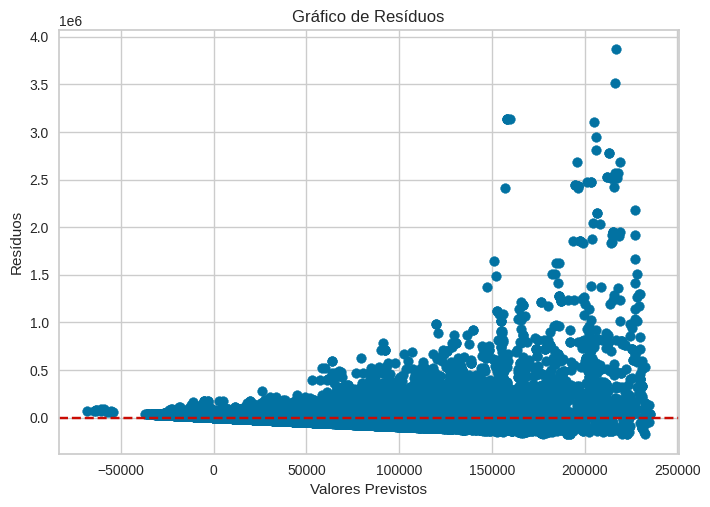


Considerações adicionais:
- Examine o gráfico de resíduos para identificar padrões e verificar a homocedasticidade.
- Compare os resultados com outros modelos para avaliar o desempenho relativo.
- Considere o contexto do problema e a importância dos diferentes tipos de erros.


In [67]:
# Avaliando o modelo com métricas de regressão
# Calcula o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)

# Calcula o R-quadrado
r2 = r2_score(y_test, y_pred)

# Calcula o erro absoluto médio
mae = mean_absolute_error(y_test, y_pred)

print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'R-quadrado (R2): {r2:.2f}')
print(f'Erro Absoluto Médio (MAE): {mae:.2f}')

# Interpretação dos resultados
print("\nInterpretação:")
print(f"- MSE: {mse:.2f} indica a média dos erros quadráticos. Valores menores indicam melhor ajuste.")
print(f"- R-quadrado: {r2:.2f} representa a proporção da variância dos dados explicada pelo modelo. Valores mais próximos de 1 indicam melhor ajuste.")
print(f"- MAE: {mae:.2f} indica o erro absoluto médio, fornecendo uma medida da magnitude típica dos erros.")

# Análise residual
residuals = y_test - y_pred

# Visualização dos resíduos (opcional)
import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals)
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Considerações adicionais
print("\nConsiderações adicionais:")
print("- Examine o gráfico de resíduos para identificar padrões e verificar a homocedasticidade.")
print("- Compare os resultados com outros modelos para avaliar o desempenho relativo.")
print("- Considere o contexto do problema e a importância dos diferentes tipos de erros.")

In [68]:
# Definindo o pipeline com PCA
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('pca', PCA(n_components=5)),  # Reduzindo para 5 componentes principais
    ('estimator', LinearRegression())
])

# Ajustando o pipeline aos dados de treino
pipeline.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = pipeline.predict(X_test)

# Avaliando o modelo com métricas de regressão
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calcula o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)

# Calcula o R-quadrado
r2 = r2_score(y_test, y_pred)

# Calcula o erro absoluto médio
mae = mean_absolute_error(y_test, y_pred)

print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'R-quadrado (R2): {r2:.2f}')
print(f'Erro Absoluto Médio (MAE): {mae:.2f}')

Erro Quadrático Médio (MSE): 5032326412.80
R-quadrado (R2): 0.22
Erro Absoluto Médio (MAE): 26289.13


In [74]:
# Supondo que 'df' seja seu DataFrame
data = df.copy()

# Configurando o ambiente do PyCaret
reg = setup(data, target = 'renda', session_id=123)

# Comparando diferentes modelos, incluindo o LightGBM
best = compare_models(include = ['lightgbm'])

# Criando um modelo LightGBM
lightgbm = create_model('lightgbm')

# Fazendo previsões no conjunto de teste usando o modelo lightgbm
predictions = predict_model(lightgbm)

# Avaliando o modelo
print(predictions)

,Description,Value
0,Session id,123
1,Target,renda
2,Target type,Regression
3,Original data shape,"(750000, 17)"
4,Transformed data shape,"(750000, 17)"
5,Transformed train set shape,"(525000, 17)"
6,Transformed test set shape,"(225000, 17)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,12217.8049,1990951169.5122,44518.5398,0.6840,0.7623,0.9189,13.0970


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12265.5948,1750066337.3874,41833.7942,0.6794,0.7610,0.9151
1,12499.7308,2529243706.1083,50291.5868,0.6546,0.7614,0.9172
2,11935.2646,1599500701.3949,39993.7583,0.6936,0.7625,0.9164
3,12329.6554,2304473954.4054,48004.9368,0.6667,0.7647,0.9229
4,12174.0621,1977257831.8997,44466.3674,0.6774,0.7610,0.9150
5,12396.3811,2099065116.0011,45815.5554,0.7018,0.7617,0.9270
6,12306.2421,2165269914.7839,46532.4609,0.6780,0.7676,0.9192
7,12111.5041,1734845431.4918,41651.4757,0.7273,0.7644,0.9249
8,12069.9281,1836090445.0403,42849.6260,0.6867,0.7601,0.9163


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12018.0028,1889773959.0044,43471.5304,0.6941,0.7653,0.9220


                   data_ref  index  sexo  posse_de_veiculo  posse_de_imovel  \
260206  1433116800000000000  11682   0.0               0.0              0.0   
427873  1441065600000000000   3136   0.0               0.0              0.0   
81591   1422748800000000000  14686   0.0               0.0              0.0   
600037  1451606400000000000  16259   0.0               0.0              0.0   
632583  1451606400000000000   1621   0.0               0.0              0.0   
...                     ...    ...   ...               ...              ...   
599958  1448928000000000000   5980   0.0               0.0              0.0   
676144  1454284800000000000   6842   0.0               0.0              0.0   
630325  1451606400000000000   9048   0.0               0.0              0.0   
8562    1420070400000000000   6257   0.0               0.0              0.0   
713705  1456790400000000000   1765   0.0               0.0              0.0   

        qtd_filhos  tipo_renda  educacao  estado_ci

,Description,Value
0,Session id,123
1,Target,renda
2,Target type,Regression
3,Original data shape,"(750000, 17)"
4,Transformed data shape,"(750000, 17)"
5,Transformed train set shape,"(525000, 17)"
6,Transformed test set shape,"(225000, 17)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,26454.3414,4076586065.1889,63848.1485,0.2532,1.4302,3.6721
1,26574.3298,5753813922.1779,75853.8985,0.2143,1.4403,3.6741
2,26017.5227,3958178933.8110,62914.0599,0.2417,1.4357,3.7114
3,26289.7838,5469539338.8636,73956.3340,0.2089,1.4300,3.6752
4,26402.3719,4702787234.3178,68576.8710,0.2327,1.4389,3.7016
5,26813.3820,5442567418.3014,73773.7583,0.2269,1.4380,3.7008
6,26492.5219,5236344048.8266,72362.5874,0.2214,1.4330,3.6841
7,26496.8418,4912665880.8358,70090.4122,0.2278,1.4262,3.6582
8,26296.4889,4521056731.4808,67238.8038,0.2286,1.4383,3.7380


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

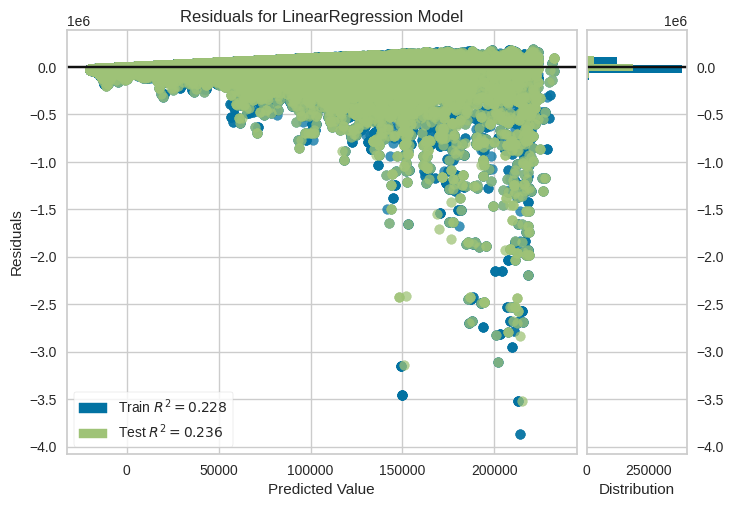

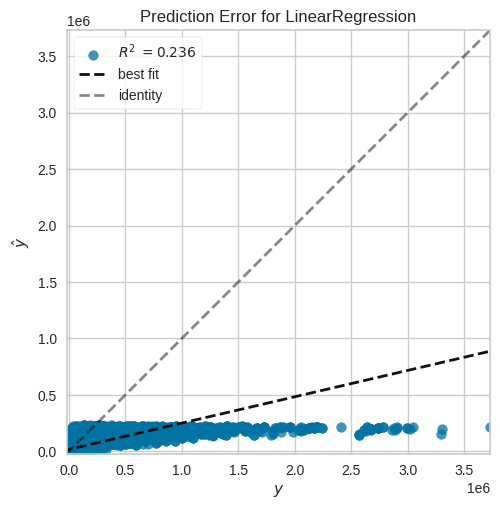

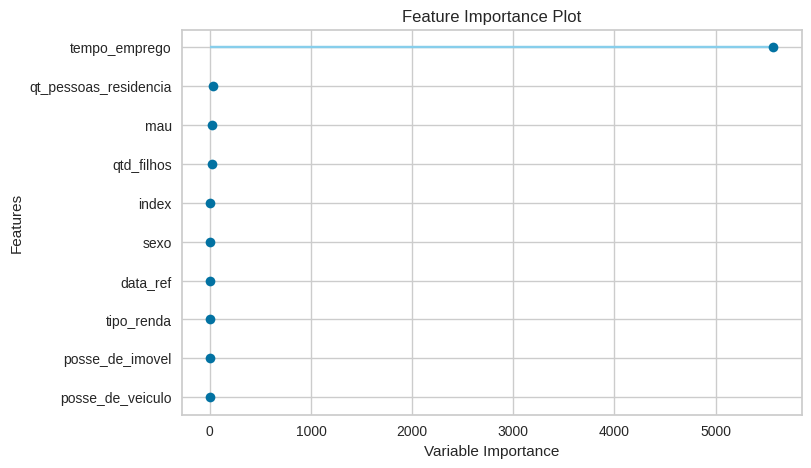

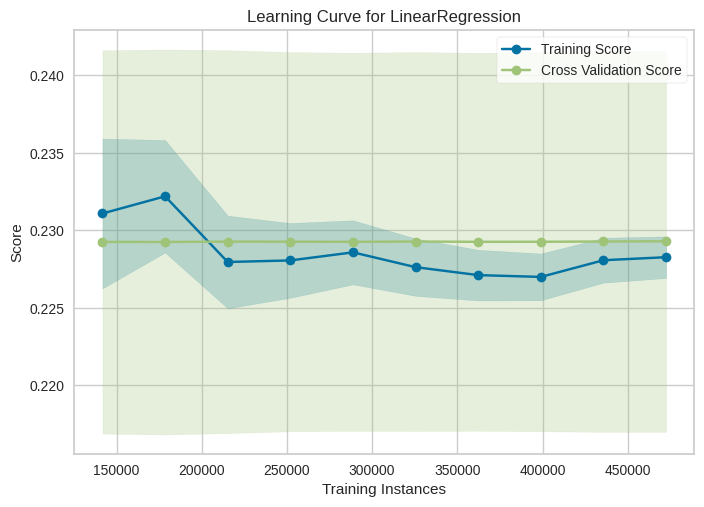

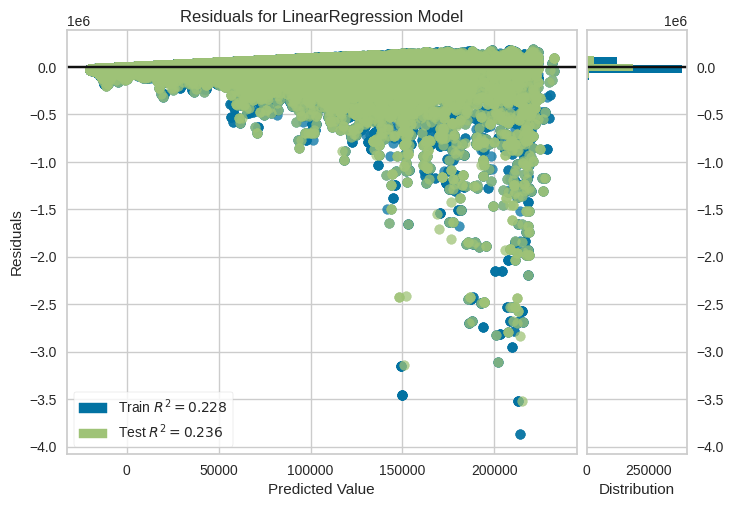

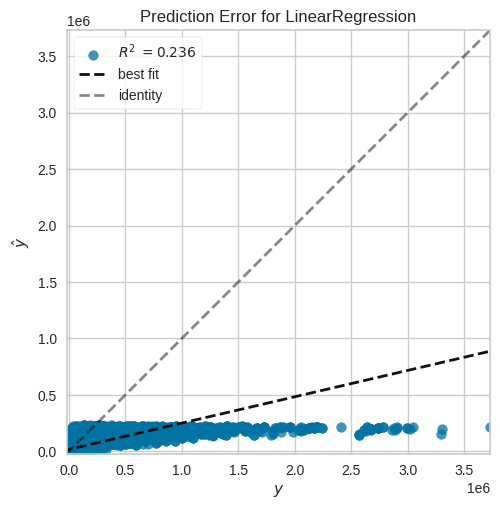

In [99]:
# Configurar o ambiente do PyCaret
_CURRENT_EXPERIMENT = setup(data=df, target='renda', session_id=123)

# Treinar o modelo
modelo = create_model('lr')  # 'lr' para regressão logística

# Chame plot_model dentro do mesmo contexto de setup
plot_model(modelo, plot='residuals')  # Gráfico de resíduos
plot_model(modelo, plot='error')       # Gráfico de erro
plot_model(modelo, plot='feature')     # Gráfico de importância das features
plot_model(modelo, plot='learning')     # Gráfico da curva de aprendizado

# Use 'residuais' ou 'erro' em vez de 'predicted_vs_actual' para tarefas de regressão
plot_model(modelo, plot='residuals')  # Gráfico de Resíduos (alternativa)
# ou
plot_model(modelo, plot='error')  # Gráfico de Erro (alternativa)